# Active learning example

In this notebook, we will use the Hylleraas Software Platform (HSP) to explore the cis-trans isomerization of butadiene, illustrating how active learning (AL) can be used to automate the training of machine-learning potentials (MLPs). This example is chosen not for its chemical significance but to exemplify how AL can be applied in generating MLPs.

MLPs are useful for the dynamical study of, for example, ion-transport processes or chemical reactions. Training accurate MLPs, for the evaluation of energies and forces, requires training data. In "passive" approaches, you train on existing data, typically generated by first-principle MD calculations. In an active approach, you selectively determine which data points are needed to improve your model, with the main aim being to reduce the data requirement and enhance the accuracy.

The notebook relies on the installation of three programs:

 - XTB
 - DeepMD
 - LAMMPS

The simplest way to install these three programs is using Conda:

```bash
conda create -n hsp_active_learning deepmd-kit lammps xtb -c conda-forge
```
*Note:* The Conda installation step can be time consuming, so please be patient.

## Exploring butadiene and setting up a reference

For this example we will assume XTB is our reference gold-standard QC method, and that our target MLP will be the XTB potential-energy surface (PES). 

Note that, if you use the above Conda installation, you will need to specify  use the image `hsp_active_learning`, created above, according to:

In [1]:
import hylleraas as hsp
from copy import deepcopy
import os

# This debug varaible is used throughout. For the final version simply turn off the debug 
# option, but it might come handy when setting up and testing the code -- to more easily 
# understand why the code fails in certain steps

debug = True
debug = False

xtb_wrk=os.path.realpath('./')+'/wrk_pbc/xtb'
xtb_conda = hsp.create_compute_settings('conda', 
                                        conda_env='hsp_al', 
                                        work_dir=xtb_wrk, 
                                        debug=debug)

# XTB for geometry optimizations
xtb_geometry_optimization = hsp.Xtb({'properties': ['energy', 
                                                    'geometry_optimization',
                                                    'gradient']}, 
                                    compute_settings = xtb_conda)

# XTB for single point calaculations of the energy and gradient
xtb_data_point = hsp.Xtb({'properties': ['energy', 'gradient']}, 
                         compute_settings = xtb_conda)

We can start by generating butadiene from a Smiles string, using
```
butadiene = hsp.Molecule("C=C-C=C")
```
the resulting coordinates will however change every time. This will mean that if we rerun the cells of this notebook, the resulting inputs and outputs will also vary. Thus we cannot use the restart options implemented in HSP. To take full advantage of this functionality we will instead use the coordinates of one such instantiation, generated by
```
butadiene.xyz_string
```

We also visually inspect the molecule.

In [2]:
import numpy as np
xyz='''10

C -1.740318000000 0.430948000000 0.064642000000
C -0.619681000000 -0.116079000000 0.467558000000
C 0.614285000000 0.118481000000 -0.245832000000
C 1.751101000000 -0.426794000000 0.149549000000
H -1.827155000000 1.074246000000 -0.797361000000
H -2.646902000000 0.238204000000 0.616993000000
H -0.608278000000 -0.746727000000 1.335847000000
H 0.597431000000 0.752131000000 -1.116548000000
H 1.799534000000 -1.067288000000 1.019770000000
H 2.679982000000 -0.257122000000 -0.377925000000'''
butadiene = hsp.Molecule(xyz, units = 'angstrom')

fig = hsp.view_molecule(butadiene, background_color='white');

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next we run an XTB geometry optimization to relax this *trans*-butadiene structure.

In [3]:
result = xtb_geometry_optimization.run(butadiene)

and print the energy (Hartree), and verify by inspection that the gradient elements are close to zero.

In [4]:
print('Energy of trans-butadiene (Hartree):', result['energy'])
print('--- Gradient', result['gradient'])

Energy of trans-butadiene (Hartree): -11.552701660534
--- Gradient [ 1.97977899e-04 -2.47811131e-04  2.81133712e-04 -2.64804664e-04
  3.84062974e-04 -4.46732825e-04  2.28796588e-04 -2.76201017e-04
  3.08977363e-04 -1.52539376e-04  1.23436479e-04 -1.23720967e-04
  3.79165160e-05  4.10387920e-05 -6.90445460e-05  4.85246350e-05
 -1.10100350e-05 -6.06061000e-07 -9.73679000e-07 -6.01078770e-05
  8.31942500e-05 -5.85582510e-05  6.79584710e-05 -7.52087110e-05
 -2.49403190e-05 -3.10079950e-05  5.11738860e-05 -1.13993500e-05
  9.64133800e-06 -9.16610100e-06]


We finally update the coordinates of our butadiene molecule with the converged xTB geometry, and inspect the converged geometry

In [5]:
butadiene.coordinates = result['final_geometry']
trans_butadiene = deepcopy(butadiene) # We store this trans-conformer explicitly by a deepcopy
hsp.view_molecule(butadiene);

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If you would like to see everything that is stored in the restult dictionary you can uncomment the next two lines 

In [6]:
#import pprint
#pprint.pprint(result)

To investigate the isomerization we perform a constrained optimization for a range of dihedral  angles between 0 and 180 degrees in order to get the potential-energy profile of the dihedral rotation, starting from the *trans* (at 180 degrees) and ending up at the *cis* geometry

In [7]:
number_of_structures = 101
input_str = f'''$constrain
force constant=0.5
dihedral: 1, 2, 3, 4, 180
$scan
   1: 180, 0, {number_of_structures}
$opt
   maxcycle=20
$end'''

scan = xtb_geometry_optimization.run(butadiene, program_opt={'input': input_str}, run_opt={'sub_dir':'scan'})

First, let's visually make sure our scan actually makes sense.
> Tilmann, for the scan the units are in Angstrom, whereas for the geometry optimization they are in Bohr. Can you verify, and easily fix this?

In [8]:
scan_structures = [hsp.Molecule({'atoms':butadiene.atoms, 'coordinates':scan['scan']['coordinates'][i]}, units='angstrom') for i in range(number_of_structures)]
hsp.view_trajectory(scan_structures);

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

All good! Next, we extract the energies, convert from Hartree to kcal/mol, and set the trans-butadiene energy as our reference zero-point energy.

In [9]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # For higher resolution display in Jupyter notebooks

def plot_energies(energies_hartree, reference_energy, add_to_plot=False, label='', ylim=None, save=None):
    """
    Rescales energies from hartree to kcal/mol and plots them against automatically generated dihedral angles.

    Parameters:
    - energies_hartree: List of energies in hartree to be rescaled and plotted.
    - add_to_plot: Flag to indicate if the plot should be added to an existing figure.
    - label: Label for the plot data.

    Returns:
    - plt: The matplotlib.pyplot object for further customization and plotting.
    """

    hartree_to_kcalmol = hsp.Constants.conversion_factor("hartree", "kcal / mol")
    
    # Determine the number of structures and generate dihedral angles
    number_of_structures = len(energies_hartree)
    dihedral_angles = np.linspace(180, 0, number_of_structures)

    # Rescale energies
    energies_kcalmol = [(energy - reference_energy) * hartree_to_kcalmol for energy in energies_hartree]
    
    if not add_to_plot:
        plt.figure(figsize=(8, 6), dpi=120)
        plt.rcParams.update({'font.size': 12})
        %config InlineBackend.figure_format = 'retina'  # For higher resolution display in Jupyter notebooks
    
    # Plot
    plt.plot(dihedral_angles, energies_kcalmol, label=label, linewidth=2)
    
    # Customization
    plt.xticks([180, 150, 120, 90, 60, 30, 0])
    plt.title('XTB Isomerization Energy Profile', fontsize=14)
    plt.ylabel('Energy (kcal/mol)')
    plt.xlabel('Dihedral Angle (degrees)')
    if ylim is None:
        ylim=[min(energies_kcalmol)-2,max(energies_kcalmol)+2]
    plt.ylim(bottom=ylim[0], top=ylim[1])
    plt.xlim(180, 0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    if label:
        plt.legend()

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight') 
    
    return plt

Next we plot the energy profile

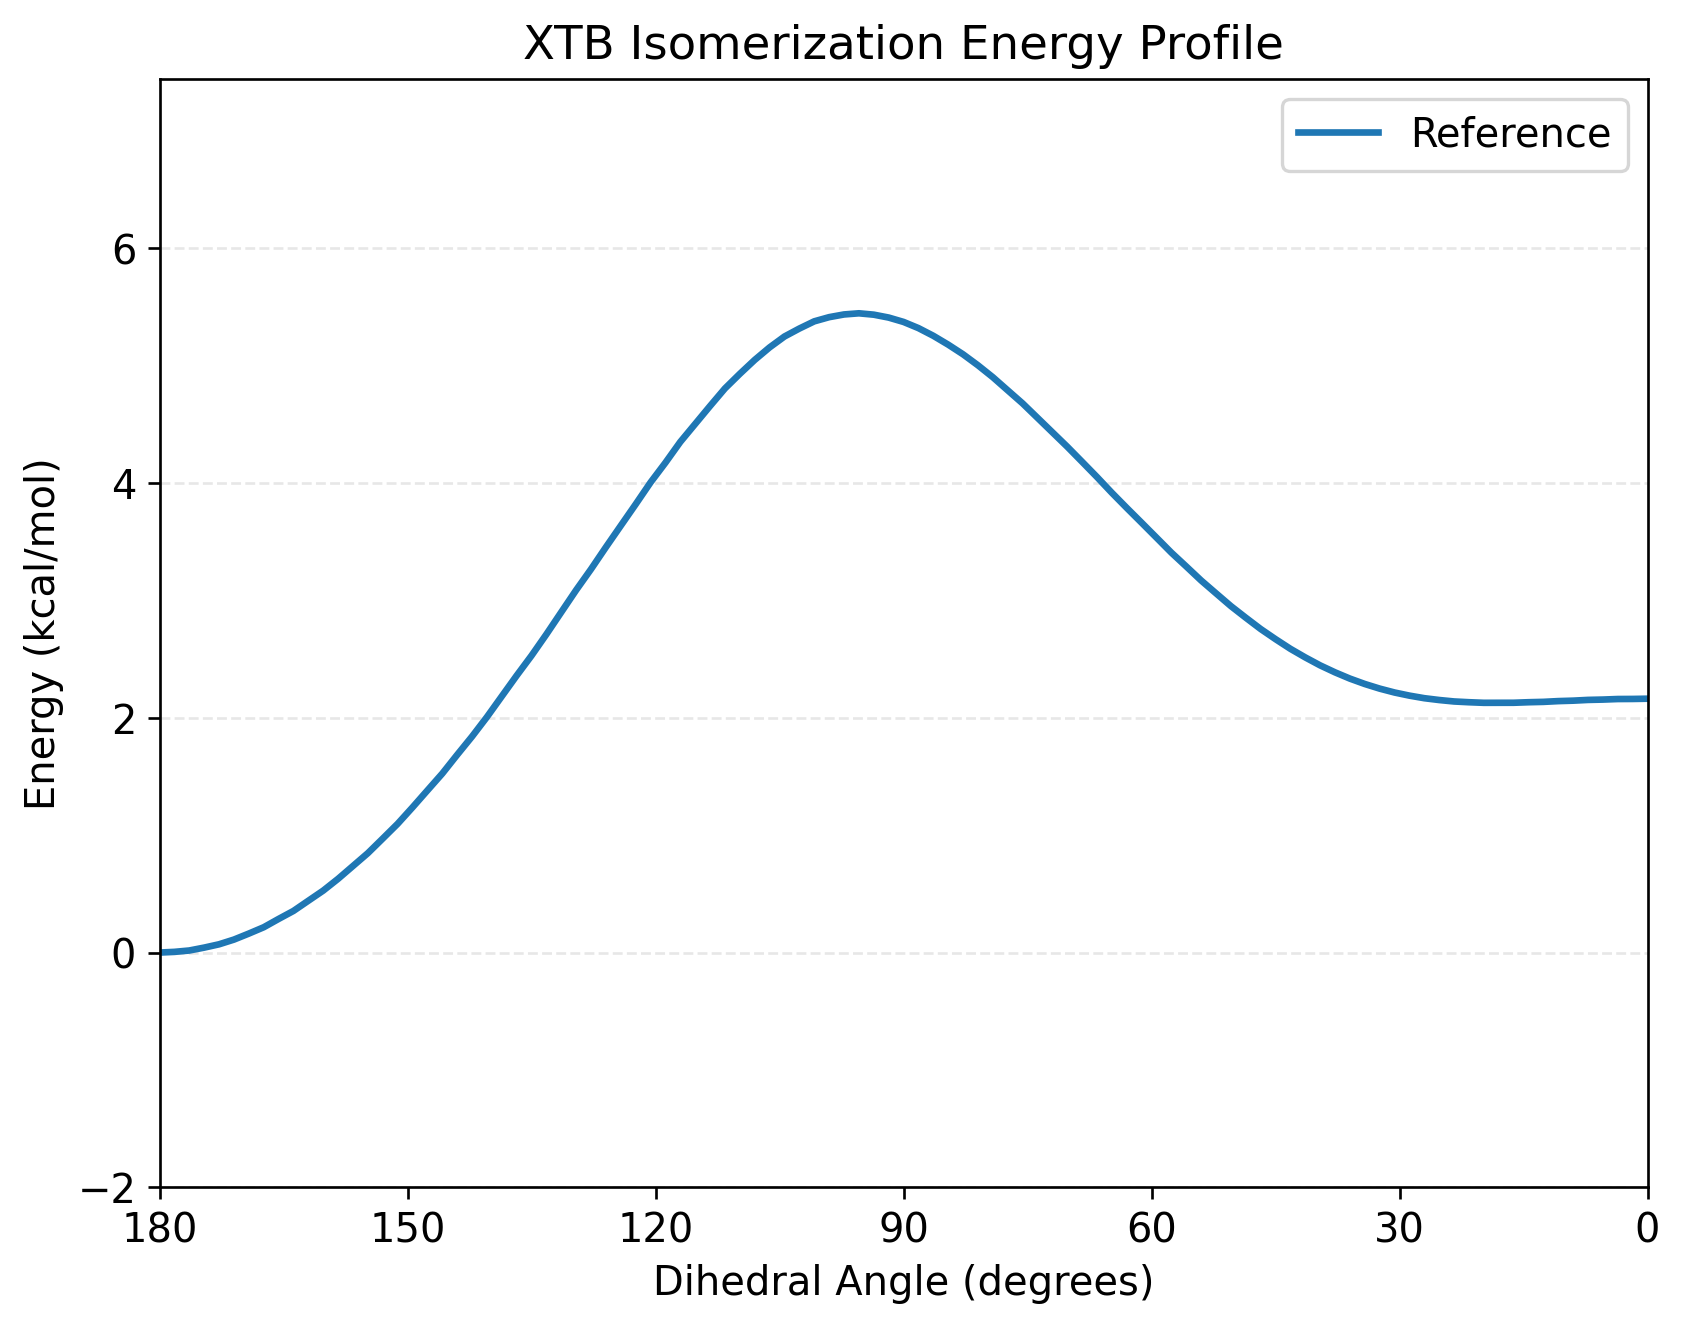

In [10]:
energies_hartree = scan['scan']['energies']
reference_energy = min(energies_hartree)
fig = plot_energies(energies_hartree, reference_energy, label = 'Reference', save='reference.png');

As we can see from the plot, the minimal for the *cis*-butadiene is not at 0 degrees dehedral angle (this is indeed a saddle point), but rather somewhere around 20 degrees. We find the *cis*-butadiene structure by relaxing a guess structure with a dihedral angle of about 20 degrees, accoding to:

In [11]:
cis_dihedral = 20
cis_guess = number_of_structures - int(number_of_structures * cis_dihedral/180)

cis_butadiene = deepcopy(scan_structures[cis_guess])

print(cis_butadiene.xyz_string)
print(f'The index of the cis-butadiene guess: {cis_guess}')
print(f'The dihedral angle of the cis-butadiene guess: {cis_butadiene.dihedral(0,1,2,3):.1f} degrees')
result = xtb_geometry_optimization.run(cis_butadiene, run_opt={'sub_dir':'cis'})

cis_butadiene.coordinates = result['final_geometry']
cis_energy = result['energy']

hartree_to_kcalmol = hsp.Constants.conversion_factor("hartree", "kcal / mol")

print(f'The cis-trans isomerization energy of butadiene: {(cis_energy - reference_energy) * hartree_to_kcalmol:.2f} kcal/mol')
print(f'The dihedral angle is: {cis_butadiene.dihedral(0,1,2,3):.1f} degrees')

hsp.view_molecule(cis_butadiene, background_color='white');

result = xtb_data_point.run(cis_butadiene)

10

C -1.405965897706 0.523326417224 0.592364118674
C -0.819271199204 -0.463416105773 -0.075086298512
C 0.591839413538 -0.533734034577 -0.422831633459
C 1.565339930876 0.175433338210 0.136399909722
H -0.860175212019 1.385386524663 0.936578247894
H -2.458833313771 0.506700784815 0.815893765821
H -1.419121937616 -1.295449026616 -0.423356634554
H 0.838172305875 -1.251663357225 -1.195676707695
H 1.377342335767 0.882079840048 0.926859326866
H 2.590672574261 0.071335619232 -0.174451094759

The index of the cis-butadiene guess: 90
The dihedral angle of the cis-butadiene guess: 18.0 degrees
The cis-trans isomerization energy of butadiene: 2.13 kcal/mol
The dihedral angle is: 18.0 degrees


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next we will locate the TS, by starting from the structure closest to the maximum energy.

In [12]:
max_energy = max(energies_hartree)
index_max = energies_hartree.index(max_energy)

dihedrals = [structure.dihedral(0,1,2,3) for structure in scan_structures]
TS_butadiene = deepcopy(scan_structures[index_max])

print(f'The dihedral angle of the TS guess is: {TS_butadiene.dihedral(0,1,2,3):.1f} degrees')

result = xtb_geometry_optimization.run(TS_butadiene, options={'optimization_target': 'transition_state'}, run_opt={'sub_dir':'TS'})

TS_energy = result['energy']
TS_gradient = result['gradient']
TS_butadiene.coordinates = result['final_geometry']

print(f'The energy barrier of butadiene: {(TS_energy - reference_energy) * hartree_to_kcalmol:.2f} kcal/mol')
print(f'The dihedral angle of the TS is: {TS_butadiene.dihedral(0,1,2,3):.1f} degrees')

hsp.view_molecule(TS_butadiene, background_color='white');

The dihedral angle of the TS guess is: 95.3 degrees
The energy barrier of butadiene: 5.44 kcal/mol
The dihedral angle of the TS is: 95.2 degrees


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

For the sake of it, lets us also include the second TS

In [13]:
TS2_butadiene = deepcopy(scan_structures[100])
hsp.view_molecule(TS_butadiene);

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

With the *trans*, TS and *cis* structures determined, we can also set up an energy diagram for the isomerization.

First we perform single-point calculations on the four geometries, and collect their energies and angles.

In [14]:
trans = xtb_data_point.run(butadiene, run_opt={'sub_dir':'buta'})
TS = xtb_data_point.run(TS_butadiene, run_opt={'sub_dir':'TS'})
cis = xtb_data_point.run(cis_butadiene, run_opt={'sub_dir':'cis'})
TS2 = xtb_data_point.run(TS2_butadiene, run_opt={'sub_dir':'TS2'})

print(cis_butadiene.coordinates)

trans_energy = trans['energy']
TS_energy = TS['energy']
cis_energy = cis['energy']
TS2_energy = TS2['energy']

trans_gradient = trans['gradient']
TS_gradient = TS['gradient']
cis_gradient = cis['gradient']
TS2_gradient = TS2['gradient']

angles = [trans_butadiene.dihedral(0,1,2,3),
          TS_butadiene.dihedral(0,1,2,3), 
          cis_butadiene.dihedral(0,1,2,3), 
          TS2_butadiene.dihedral(0,1,2,3)]
diagram_energies_hartree = [trans_energy, TS_energy, cis_energy, TS2_energy]

[[-1.4059659   0.52332642  0.59236412]
 [-0.8192712  -0.46341611 -0.0750863 ]
 [ 0.59183941 -0.53373403 -0.42283163]
 [ 1.56533993  0.17543334  0.13639991]
 [-0.86017521  1.38538652  0.93657825]
 [-2.45883331  0.50670078  0.81589377]
 [-1.41912194 -1.29544903 -0.42335663]
 [ 0.83817231 -1.25166336 -1.19567671]
 [ 1.37734234  0.88207984  0.92685933]
 [ 2.59067257  0.07133562 -0.17445109]]


Second, we plot the diagram

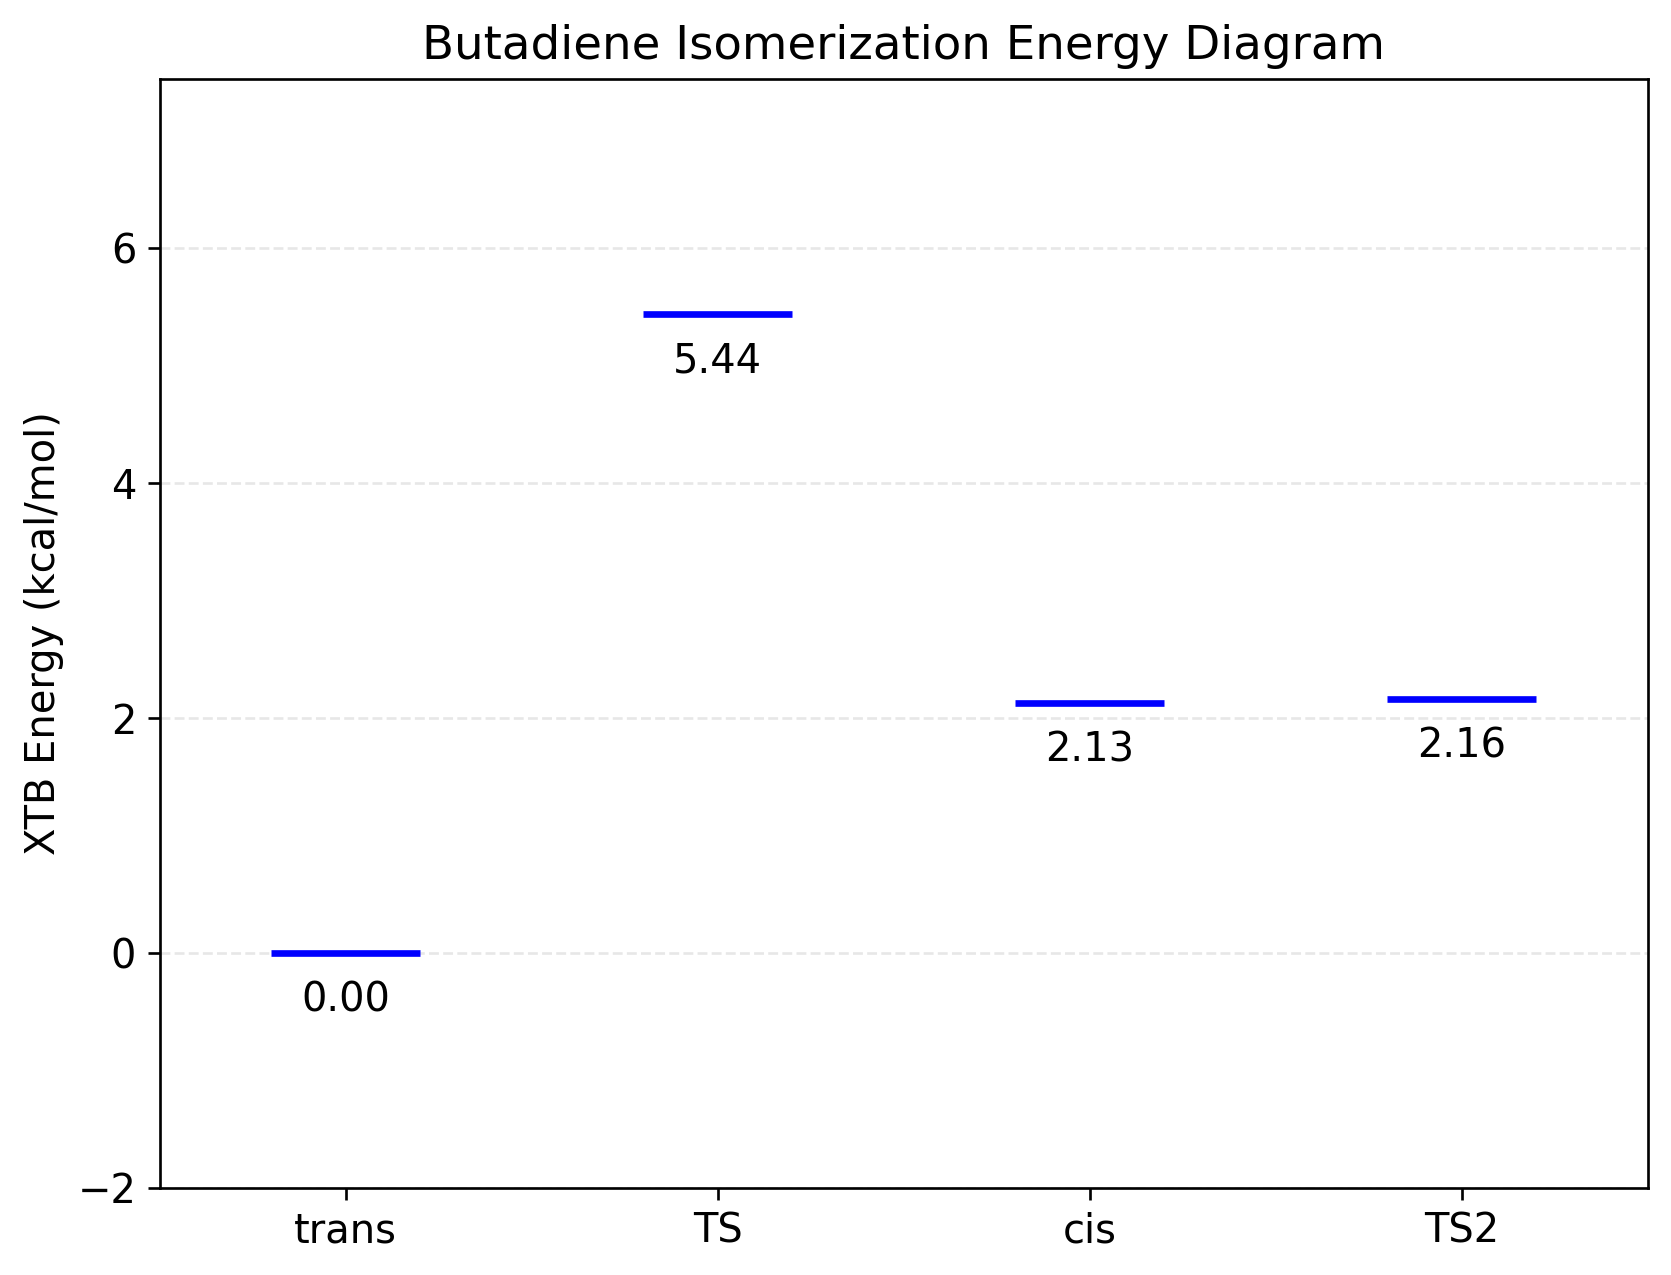

In [15]:
%config InlineBackend.figure_format = 'retina'  # For higher resolution display in Jupyter notebooks

import matplotlib.pyplot as plt

hartree_to_kcalmol = 627.509
lowest_energy = min(diagram_energies_hartree)
E_kcalmol = [(energy - lowest_energy) * hartree_to_kcalmol for energy in diagram_energies_hartree]

labels = ['trans', 'TS', 'cis', 'TS2']

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(8, 6), dpi=120)

# Plotting each energy level as a horizontal line
for i, energy in enumerate(E_kcalmol):
    plt.hlines(energy, i - 0.2, i + 0.2, colors='blue', linewidth=2)
    plt.text(i, energy - 0.5, f'{energy:.2f}', ha='center')

plt.xticks(range(len(labels)), labels)
plt.title('Butadiene Isomerization Energy Diagram', fontsize=14)
plt.ylabel('XTB Energy (kcal/mol)')

# Setting limits and customizing grid appearance
plt.ylim(bottom=min(E_kcalmol)-2, top=max(E_kcalmol)+2)
plt.xlim(-0.5, len(labels)-0.5)

plt.grid(True, axis='y', linestyle='--', alpha=0.3)  # Make grid less obtrusive

plt.savefig('isomerization.png', dpi=300, bbox_inches='tight') 

plt.show()

We have now a better understanding of the isomerization profile of the *cis-trans* process. 

Before we proceed to the passive and active learning approaches, we will generate a reference dataset from the scan geometries, for testing the various ML approaches.

To set up the reference, we start by running the single-point calculations. We here use `asyncio` to gather the results. This will run the calculations concurrently, and only proceed when all the results have been gathered. For a local setup this is not actually neccessary. However, if our `xtb_data_point` is set up to use a Slurm scheduler, this syntax allow us to submit and run the calculations in parallel. In either case, we will only proceed once all the calculations are finished.

In [16]:
import asyncio

results = await asyncio.gather(*[xtb_data_point.arun(structure, run_opt={'sub_dir':'reference'}) for structure in scan_structures])

Next, we generate the dataset for the ouputs and inputs, and finally inspect the reference data, according to

In [17]:
reference_path=xtb_wrk + '/reference'
reference = hsp.DataSet(reference_path,
                        parser=xtb_data_point.OutputParser)

# Rename the coordinates
reference.data.rename(columns={'input_geometry': 'coordinates'}, inplace=True)
        
# Sort the data according to ascending dihedral engles
def calculate_dihedral(row):
    coor = row['coordinates']
    atoms = row['atoms']
    geo = hsp.Molecule({'atoms':atoms, 'coordinates':coor}, units='angstrom')
    dihedral = geo.dihedral(0, 1, 2, 3)
    if dihedral < -1:
        dihedral = 360 + dihedral
    return dihedral

reference.data['dihedrals'] = reference.data.apply(calculate_dihedral, axis=1)

reference.data = reference.data.sort_values(by='dihedrals', ascending=False)

def flatten_data_column(data, column):
    for i in range(len(data)):
        # Check if the item is indeed a list of lists
        if all(isinstance(sublist, list) for sublist in data.at[i, column]):
            # Only then proceed to flatten
            flattened_list = [value for sublist in data.at[i, column] for value in sublist]
            data.at[i, column] = flattened_list
        else:
            # If it's not a list of lists, you might want to handle it differently or skip
            print(f"Item at index {i} is already flattened or is not a list of lists.")

flatten_data_column(reference.data, 'coordinates')

Let us finally plot the recalculated data to see if we did everything correctly

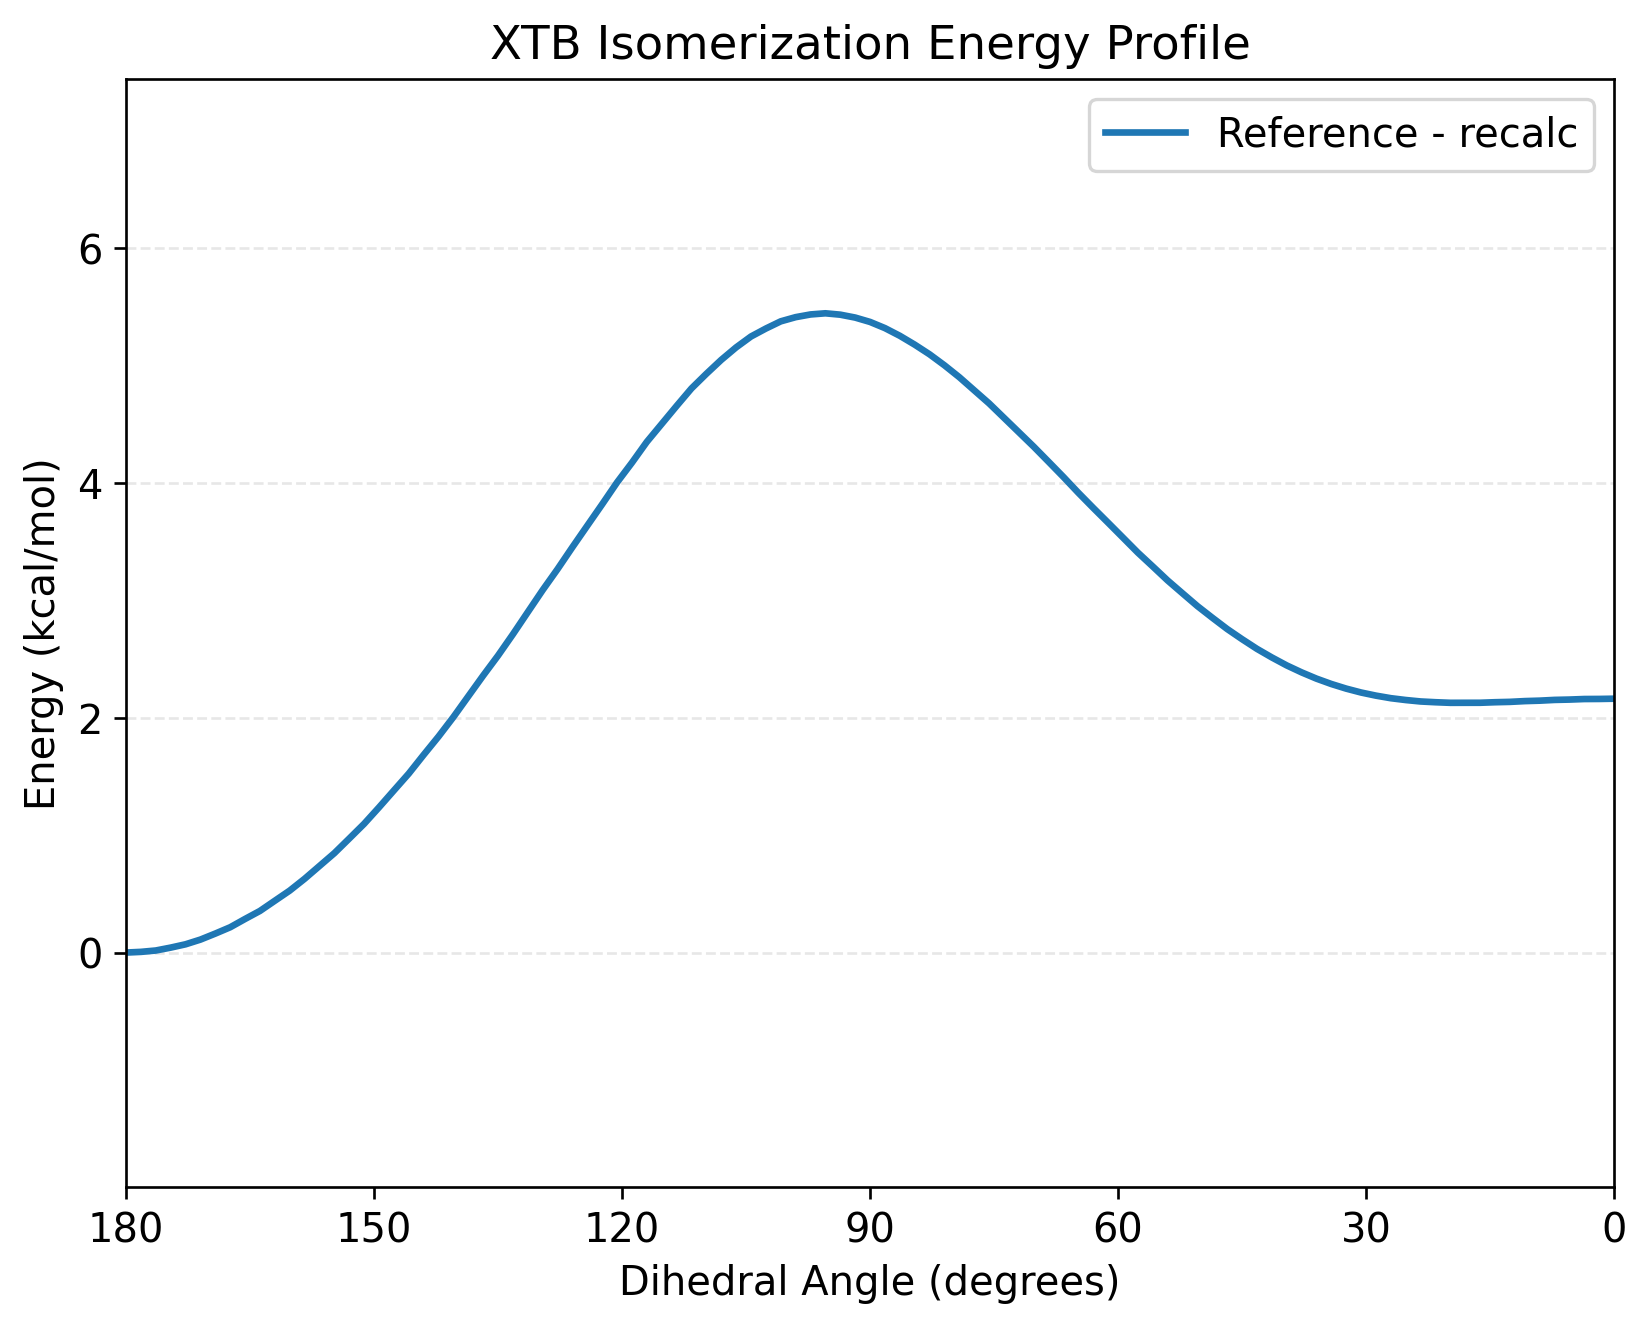

In [18]:
fig = plot_energies(reference.data['energy'], reference_energy, label = 'Reference - recalc', save='reference_recalc.png');

## Passive learning

Having expored our system, we are now ready to test out different machine-learning approaches. We start here by exploring the so-called *passive* approach, where we 

- first run an MD calculation to genereate data points
- train the MLPs using these data points
- test our model

Typically this is an iterative approach, where we will have to also explore *how* to run the MD, and the number of data points required before we get an accuracy we can be satisfied with. Note that we will not in any way target the isomerization energy profile, but merly use it as a way to test our MLPs.

We start by defining a function to run the MD, and generate a dataset with the energies and forces of all the MD snapshots.

In [19]:
async def xtb_MD(starting_geomerty, temperature, number_of_dumps, sub_dir='md'):
    '''Function that runs an XTB molecular dynamics simulation.
    
    The time step is 5 fs, but only every tenth geometry is stored'''

    # --- Start by running the MD
    time = 50.0*number_of_dumps/1000
    input_str=f'''$md
      temp={temperature} # in K
      time= {time}  # in ps
      dump= 50.0  # in fs
      step=  5.0  # in fs
      velo=false
      nvt =true
      hmass=4
      shake=2
      sccacc=2.0
    $end
    '''
    xtb_md =  hsp.Xtb({'properties': 'molecular_dynamics'}, compute_settings = xtb_conda)
    result = xtb_md.run(starting_geomerty, program_opt={'input': input_str}, run_opt={'sub_dir':sub_dir})

    coordinates = result['trajectories']['coordinates']

    # --- Next we are ready to calculate the data points from the MD geometries
    geometries = []
    for i in range(number_of_dumps):
        geometry = deepcopy(starting_geomerty)
        geometry.coordinates=coordinates[i]
        geometries.append(geometry)

    # Here we perform the data point calculations
    results = await asyncio.gather(*[xtb_data_point.arun(geo, run_opt={'sub_dir':f'{sub_dir}_data'}) for geo in geometries])

    # Extract results for generating a dataset
    path = xtb_wrk + f'/{sub_dir}_data'
    ds = hsp.DataSet(path, parser=xtb_data_point.OutputParser)

    # Extract C=C-C=C dihedral angles
    dihedrals = []
    for geo in geometries:
        dihedrals.append(geo.dihedral(0,1,2,3))

    # Add the dihedrals to the pandas data sheet
    ds.data['dihedrals'] = dihedrals

    return ds

Next we generate an MD data set with $n$ frames, at a temperature of 20 degrees celsius.

> This calculation will likely take quite some minutes. On a 2.3 GHz 8-core intel i9, this took about 15 minutes for $n=1000$. You can easily proceed also by using a lower number of data frames, for example 50 or 200.

In [20]:
n=50
t=20
t20 = await xtb_MD(butadiene, 273.15+t, n, 't20')

For now the model inference, ie. the evaluation of the model, is only implemented for periodic systems. As such we will also need to train the data on a periodic system, which we emulate by adding a large unit cell for each data point in our Pandas datasheet.

In [21]:
def augment_data_with_lattice(data, entry, factor, N):
    # Create a list of N 3x3 identity matrices, each multiplied by a factor
    cell = [np.eye(3) * factor for _ in range(N)]
    
    # Flatten each 3x3 matrix in the cell list
    flattened_cell = [matrix.flatten() for matrix in cell]
    
    # Update the data entry with the flattened cells
    data[entry] = flattened_cell

augment_data_with_lattice(t20.data, 'cell', 50.0, n)

Let us inspect the MM datapoint before we proceed.

In [22]:
t20.data

,input_geometry,atoms,gradient,version,cite,omp_threads,Reference,basis_functions,atomic_orbitals,electrons,...,orbital_occupations,orbital_homo,orbital_lumo,coordination_numbers,molecular_dipole,molecular_quadrupole,molecular_quadrupole_order,gradient_norm,dihedrals,cell
0,"[[-1.758792198496, 0.488609923081, 0.084780896...","[C, C, C, C, H, H, H, H, H, H]","[-0.000982293806, -0.008253154471, -0.01117791...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.842, 2.89, 2.895, 2.837, 0.926, 0.926, 0.92...",0.197,"[0.261, -0.482, -0.508, -0.459, -1.522, 0.248]","[xx, xy, yy, xz, yz, zz]",0.028757329416,-179.999886,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
1,"[[-1.649834761847, 0.524651371548, 0.191653691...","[C, C, C, C, H, H, H, H, H, H]","[0.02015416698, 0.012245020214, 0.008497904477...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.87, 2.914, 2.922, 2.861, 0.926, 0.926, 0.92...",0.079,"[0.272, -0.447, -0.533, 0.228, -1.714, 0.261]","[xx, xy, yy, xz, yz, zz]",0.044209350379,-159.293699,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
2,"[[-1.812574088505, 0.423497025153, 0.051543886...","[C, C, C, C, H, H, H, H, H, H]","[-0.007183576556, 0.008608273681, 0.0048916808...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.836, 2.889, 2.889, 2.836, 0.926, 0.926, 0.9...",0.064,"[0.560, -0.332, -0.651, -0.594, -1.285, 0.092]","[xx, xy, yy, xz, yz, zz]",0.052652709947,-155.550273,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
3,"[[-1.767780100749, 0.361255713891, 0.039999237...","[C, C, C, C, H, H, H, H, H, H]","[-0.001287849305, -0.009980958944, 0.000237307...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.844, 2.893, 2.897, 2.84, 0.926, 0.926, 0.92...",0.033,"[0.747, -0.215, -0.788, -0.374, -1.616, 0.041]","[xx, xy, yy, xz, yz, zz]",0.027981163674,-164.129998,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
4,"[[-1.760985003349, 0.368729186591, 0.059175301...","[C, C, C, C, H, H, H, H, H, H]","[0.00044686763, -0.004644546387, 0.00423712348...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.844, 2.904, 2.897, 2.851, 0.926, 0.926, 0.9...",0.141,"[0.593, -0.306, -0.649, -0.206, -1.690, 0.057]","[xx, xy, yy, xz, yz, zz]",0.024708957320,178.124980,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
5,"[[-1.817622483182, 0.429511708566, 0.047982212...","[C, C, C, C, H, H, H, H, H, H]","[0.005127531327, -0.008878993949, -0.011345543...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.836, 2.891, 2.889, 2.838, 0.926, 0.926, 0.9...",0.031,"[0.617, -0.477, -0.626, -0.648, -1.594, 0.009]","[xx, xy, yy, xz, yz, zz]",0.037965906523,171.517642,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
6,"[[-1.716186108647, 0.54973995613, 0.1846434144...","[C, C, C, C, H, H, H, H, H, H]","[-0.003012107164, 0.011300749123, -0.000256325...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.842, 2.898, 2.895, 2.845, 0.926, 0.926, 0.9...",0.024,"[0.252, -0.062, -0.617, -0.242, -1.413, 0.364]","[xx, xy, yy, xz, yz, zz]",0.035586168986,172.083832,"[50.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 50.0]"
7,"[[-1.754324864542, 0.341916545009, 0.023338300...","[C, C, C, C, H, H, H, H, H, H]","[-0.0022768491, 0.008069605087, 0.000548923708...",6.6.1,10.1002/wcms.1493,16,10.1021/acs.jctc.8b01176,22,22,22,...,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",11,12,"[2.842, 2.903, 2.895, 2.85, 0.926, 0.926, 0.92...",0.264,"[0.171, -0.193, -0.561, -0.379, -1.511, 0.390]","[xx, xy, yy, xz, yz, zz]",0.021422210851,-1

Here you may notice that the dihedral values jump between +/- roughly 180 degrees, therefor we instead map them to positive valules only, i.e. from (-180,180) to (0,360).

In [23]:

t20.data['dihedrals'] = t20.data['dihedrals'].apply(lambda x: x + 360 if x < 0 else x)

In the following we would like to investigate these data points, so in the following cell we first set up a function to plot data

In [24]:
def plot_data(data, column, ylabel, title, ref=0.0, horizontal_line=None, save=None):
    """
    Plot data as a function of geometry number from a given DataFrame and optionally add a horizontal line at a given y value.
    
    Parameters:
    - data: DataFrame containing the data to plot.
    - column: The column name in the DataFrame to plot.
    - ylabel: Label for the y-axis.
    - title: Title of the plot.
    - ref: Reference value for adjusting data, used when plotting 'energies'.
    - horizontal_line: Y value at which to draw a horizontal line (optional).
    """
    # Generate a sequence of row numbers equal to the length of the DataFrame
    row_numbers = range(1, len(data) + 1)
    
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    hartree_to_kcalmol = hsp.Constants.conversion_factor("hartree", "kcal / mol")
    if column == 'energy' or column == 'energies':
        reference_energy = min(data[column])  # Assuming adjustment by the minimum energy
        energies_kcalmol = [(energy - reference_energy) * hartree_to_kcalmol for energy in data[column]]
        plt.plot(row_numbers, energies_kcalmol, marker='o', linestyle='-', markersize=2)
    else:
        plt.plot(row_numbers, data[column], marker='o', linestyle='-', markersize=2)
    
    # Optionally add a horizontal line at the specified y value
    if horizontal_line is not None:
        plt.axhline(y=(horizontal_line-ref)*hartree_to_kcalmol, color='red', linestyle='--', linewidth=2)
    
    plt.title(title)
    plt.xlabel('Geometry Number')
    plt.ylabel(ylabel)
    plt.grid(True)  # Show grid lines for better readability
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

We are then ready to invesitgate the dihedral angles as a function of the MD frames.

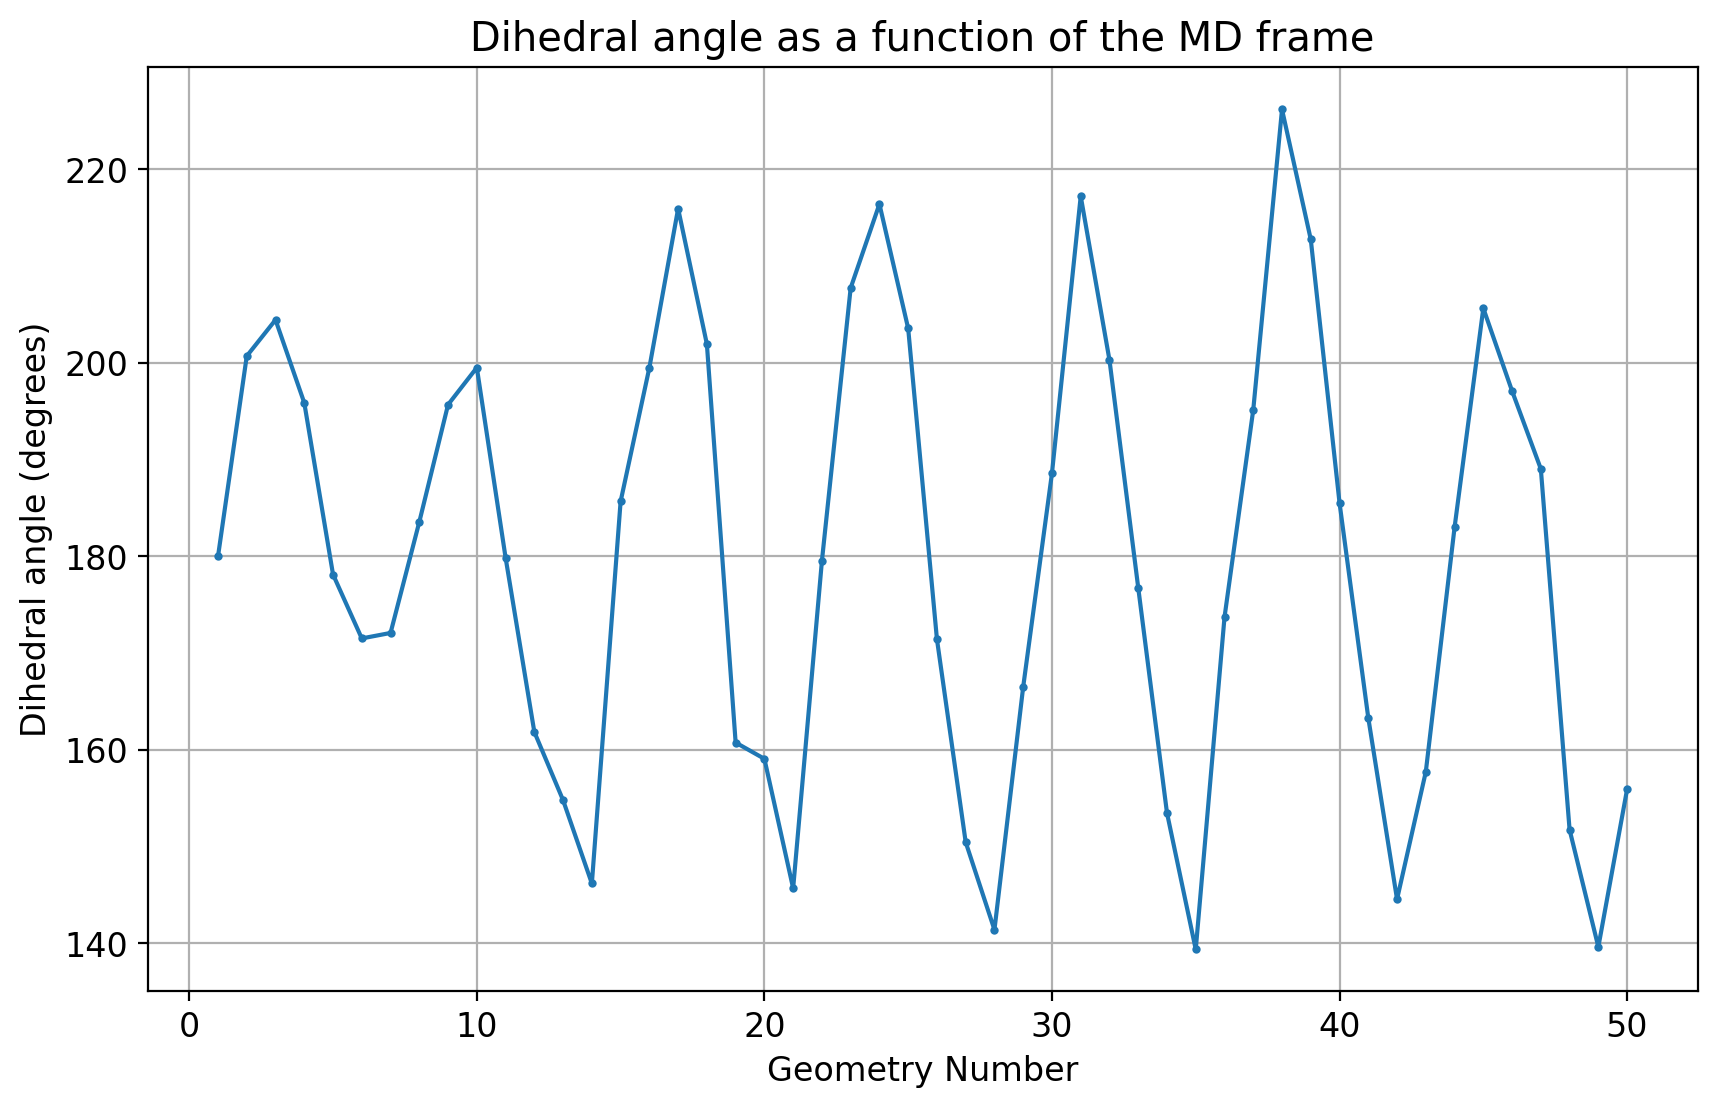

In [25]:
plot_data(t20.data, 'dihedrals', 'Dihedral angle (degrees)', 'Dihedral angle as a function of the MD frame', save=f'dihedral_{n}_0.png')

In our case, we do not have a sufficient amount of MD steps to see any actual dihedral isomerization. Before we proceed, let us also plot the electronic energies.

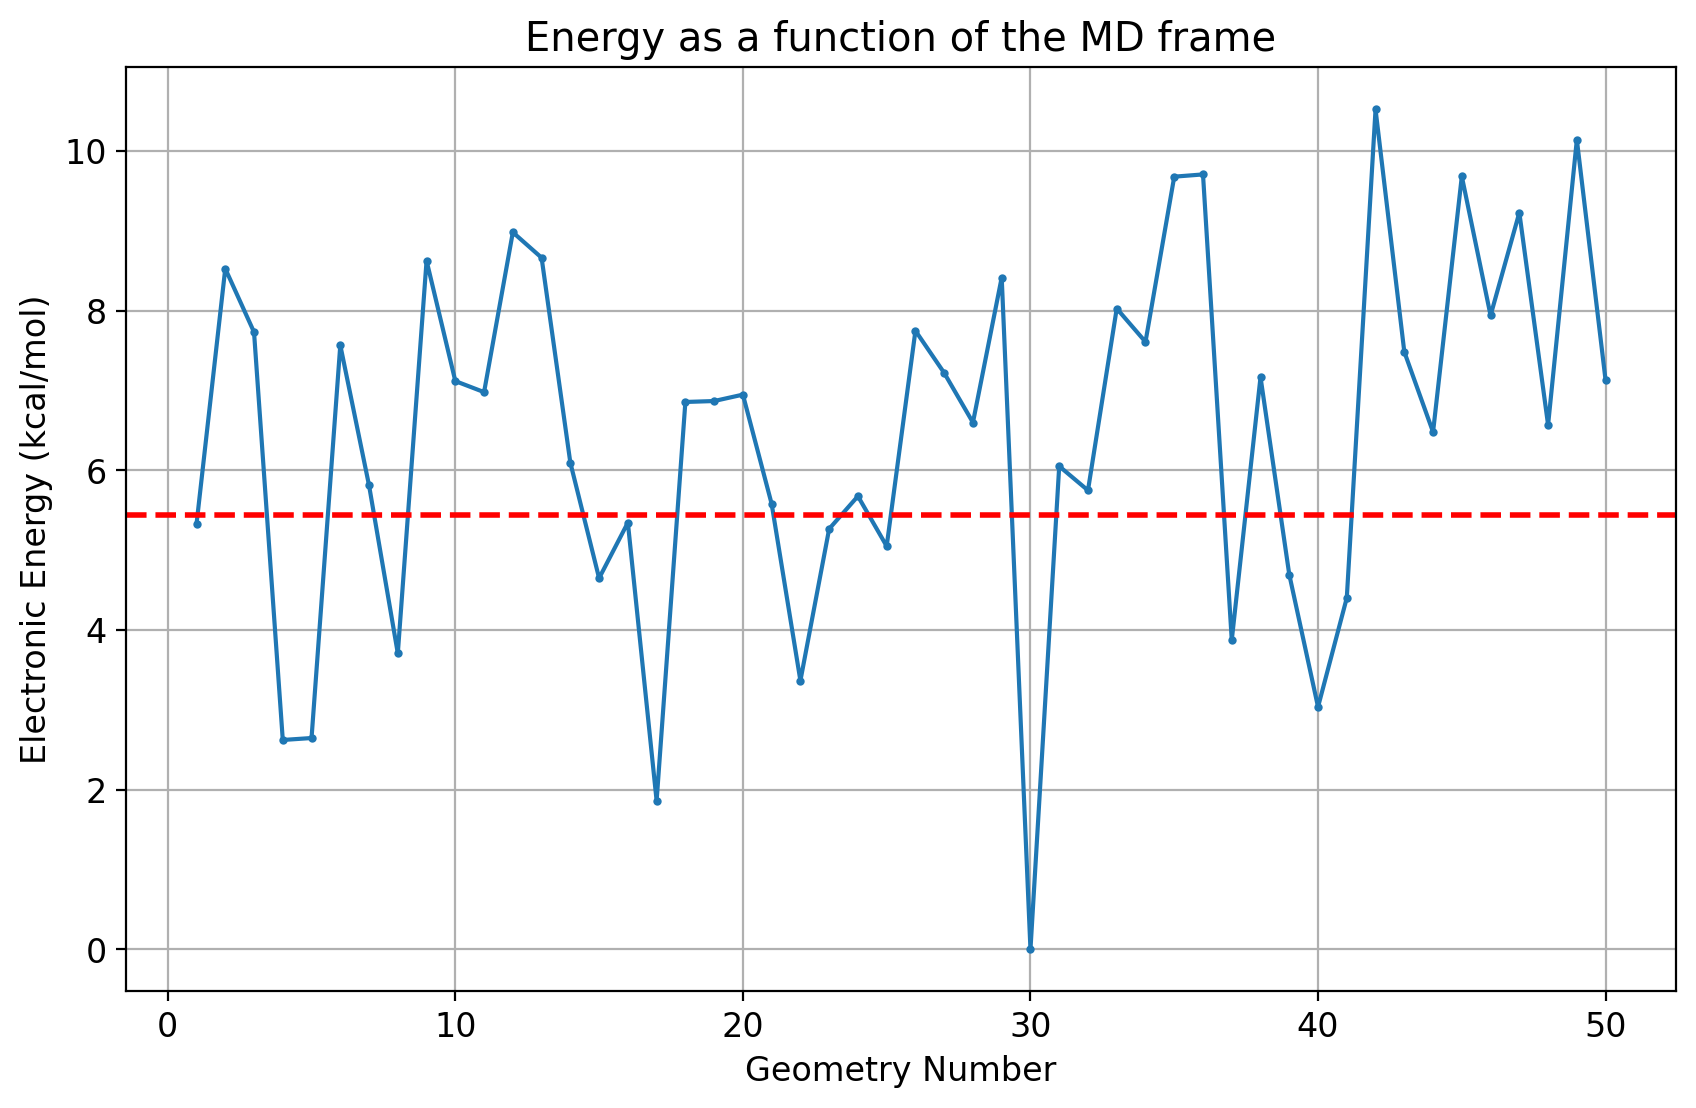

In [26]:
plot_data(t20.data, 'energy', 'Electronic Energy (kcal/mol)', 'Energy as a function of the MD frame', ref = reference_energy, 
          horizontal_line=TS_energy, save=f'energy_{n}_0.png')

As can be seen from the electronic energies, there is clearly enough energy in the system to isomerize (the isomerization barrier is 5.44 kcal/mol). However, as can be seen from the plot of the dihedral angles, we rather see only small osciallations around the equilibrium *trans* dihedral angle of 180 degrees. It is a typical feature for MD  calculations to oscillate around equilibirum states. As a result, traning MLPs based on such calculations will typically give a bias towards equilibrium states. Furthermore, important parts of the PES may never be explored, thus resulting in MLPs that perform poorly unless great care is taken in the construction of the training data.

Still, let us use the MD data points generated to train our MLP to see how it actually performs byt comparing to our reference data points. 

We start by setting up our DeepMD engine.

In [27]:
import json

deepmd_wrk=os.path.realpath('./')+'/wrk_pbc/deepmd'
deepmd_conda = hsp.create_compute_settings('conda', 
                                            conda_env='hsp_al', 
                                            work_dir=deepmd_wrk, 
                                            debug=debug)

deepmd_input_dict = json.load(open('templates/deepmd_template.json', 'r'))
deepmd_engine = hsp.DeepMD(
    {
        'input': deepmd_input_dict,
        'debug': False,
        'check_version': False,
        'options': {},
    }, 
    compute_settings = deepmd_conda
)

We again rename the coordinates and flatten them

In [28]:
t20.data.rename(columns={'input_geometry': 'coordinates'}, inplace=True)

flatten_data_column(t20.data, 'coordinates')

Next we train our model based on these data points. We first transform our dataset into a DeepMD friendly format, and second train our model.

In [29]:
dp_data = deepmd_engine.get_data(t20, data_dir=f'{deepmd_wrk}/wrk/t20')

model = deepmd_engine.train(dp_data, run_opt={"sub_dir": "wrk/trained_models"})
# This step takes a lot of time, you can monitor the progress in the trained_models directory

We can then test our model on the reference geometries, and make a plot to compare the two.

In [30]:
predictions = hsp.DataSet(deepmd_engine.infer(model["model"], reference))

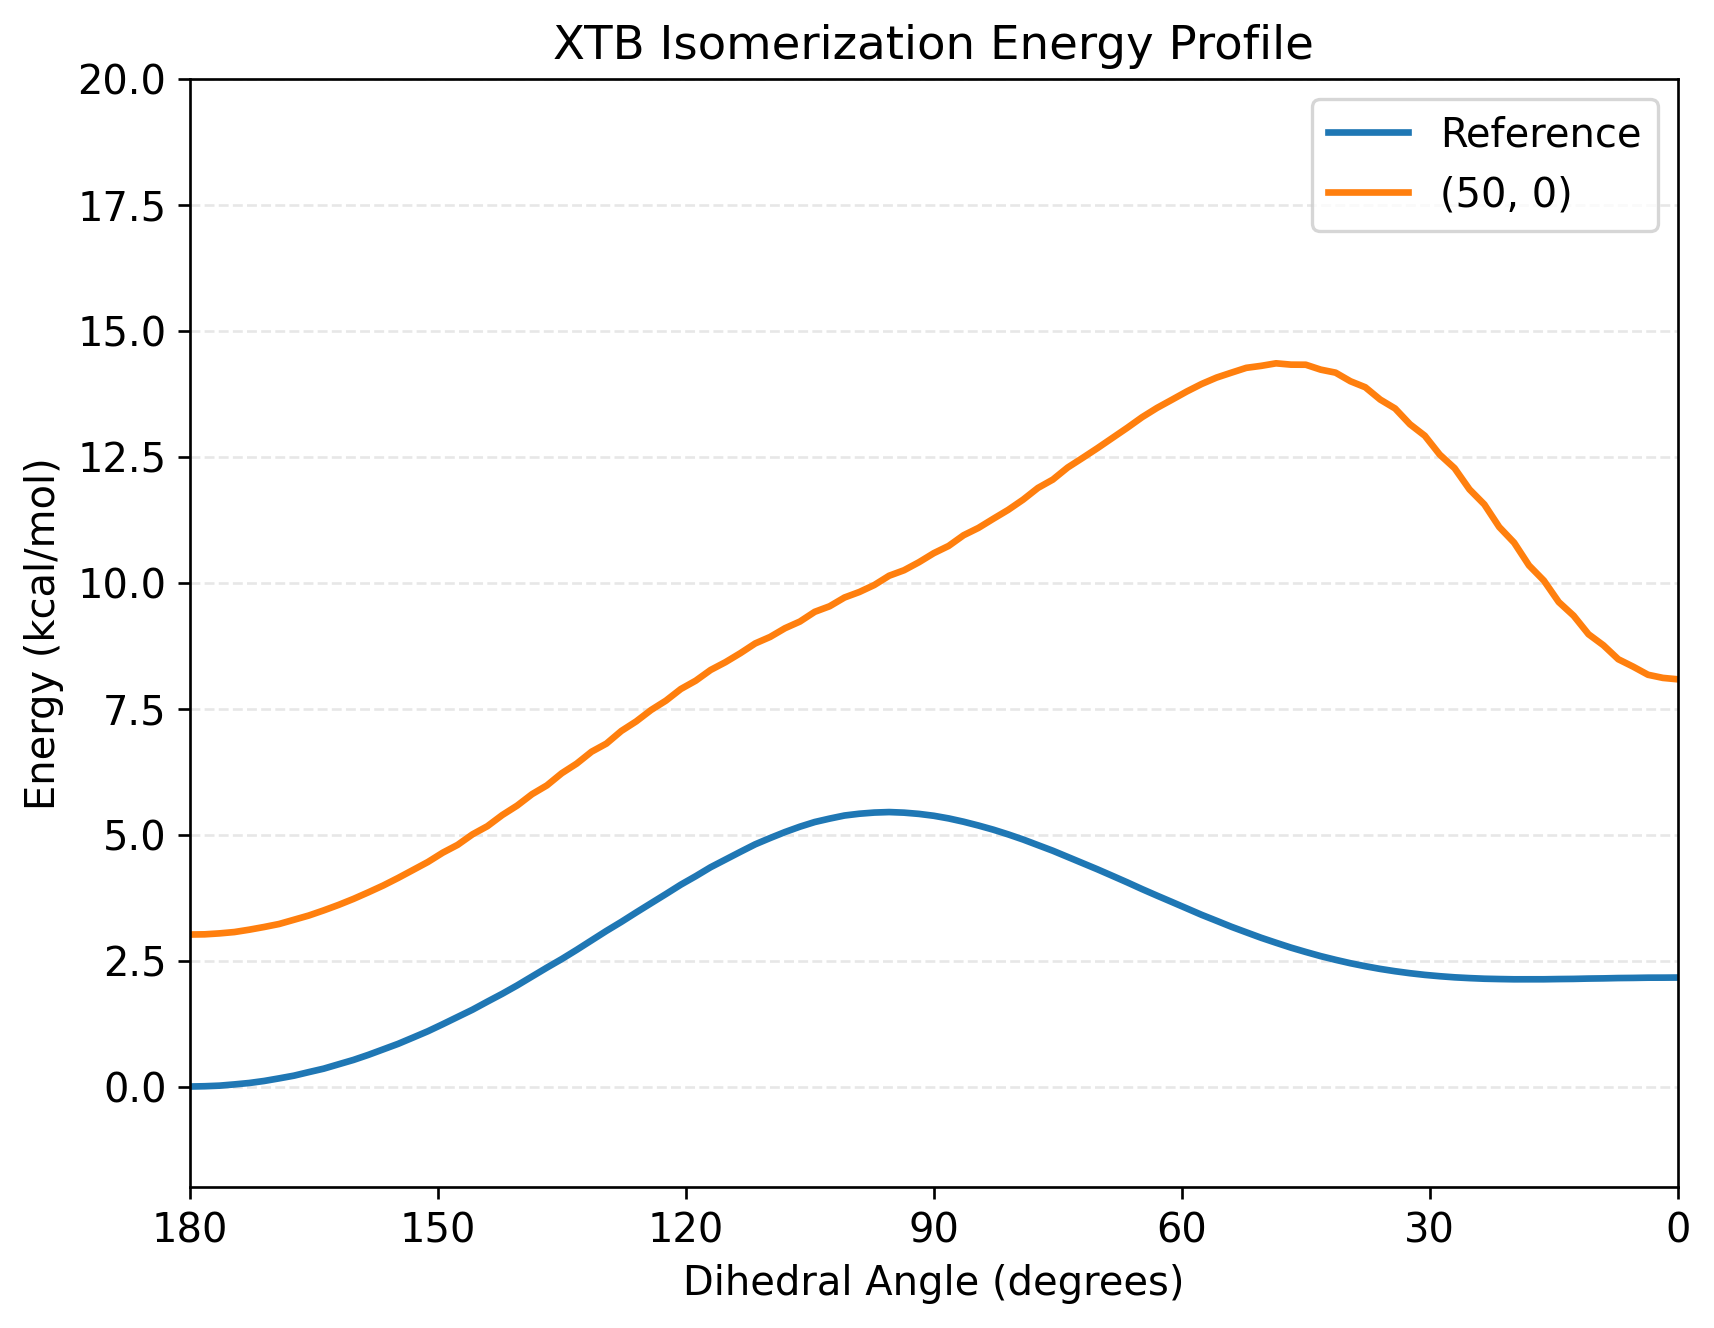

In [31]:
ref_M = min(predictions.data['energy'])
ylim=[-2,20]
plt = plot_energies(energies_hartree, reference_energy, label = 'Reference', ylim=ylim);
plt = plot_energies(predictions.data['energy'], reference_energy, add_to_plot=True, label = f'({n}, 0)', ylim=ylim, save=f'model1_{n}_0.png');

As can be seen, our model captures some of the involved physics, but is also quite off. Let us for the sake of it calculate the barrier along the xTB dihedral scan. The reference barrier of xTB was 5.44 kcal/mol.

In [32]:
barrier = (max(predictions.data['energy'])-min(predictions.data['energy']))*hsp.Constants.conversion_factor("hartree", "kcal / mol")
print(f"Isomerization barrier for model 1 is {barrier:.2f} kcal/mol")

Isomerization barrier for model 1 is 11.33 kcal/mol


We are off by more than a factor 2. Next let us also add traing data around the *cis*-butadiene geometry.

In [33]:
t20_cis = await xtb_MD(cis_butadiene, 273.15+t, n, 'cis_t20')

# Rename the coordinates
t20_cis.data.rename(columns={'input_geometry': 'coordinates'}, inplace=True)

flatten_data_column(t20_cis.data, 'coordinates')

augment_data_with_lattice(t20_cis.data, 'cell', 50.0, n)

Again, we inspect the dihedral angles to confirm that the generated structures are indeed centered around the *cis*-state.

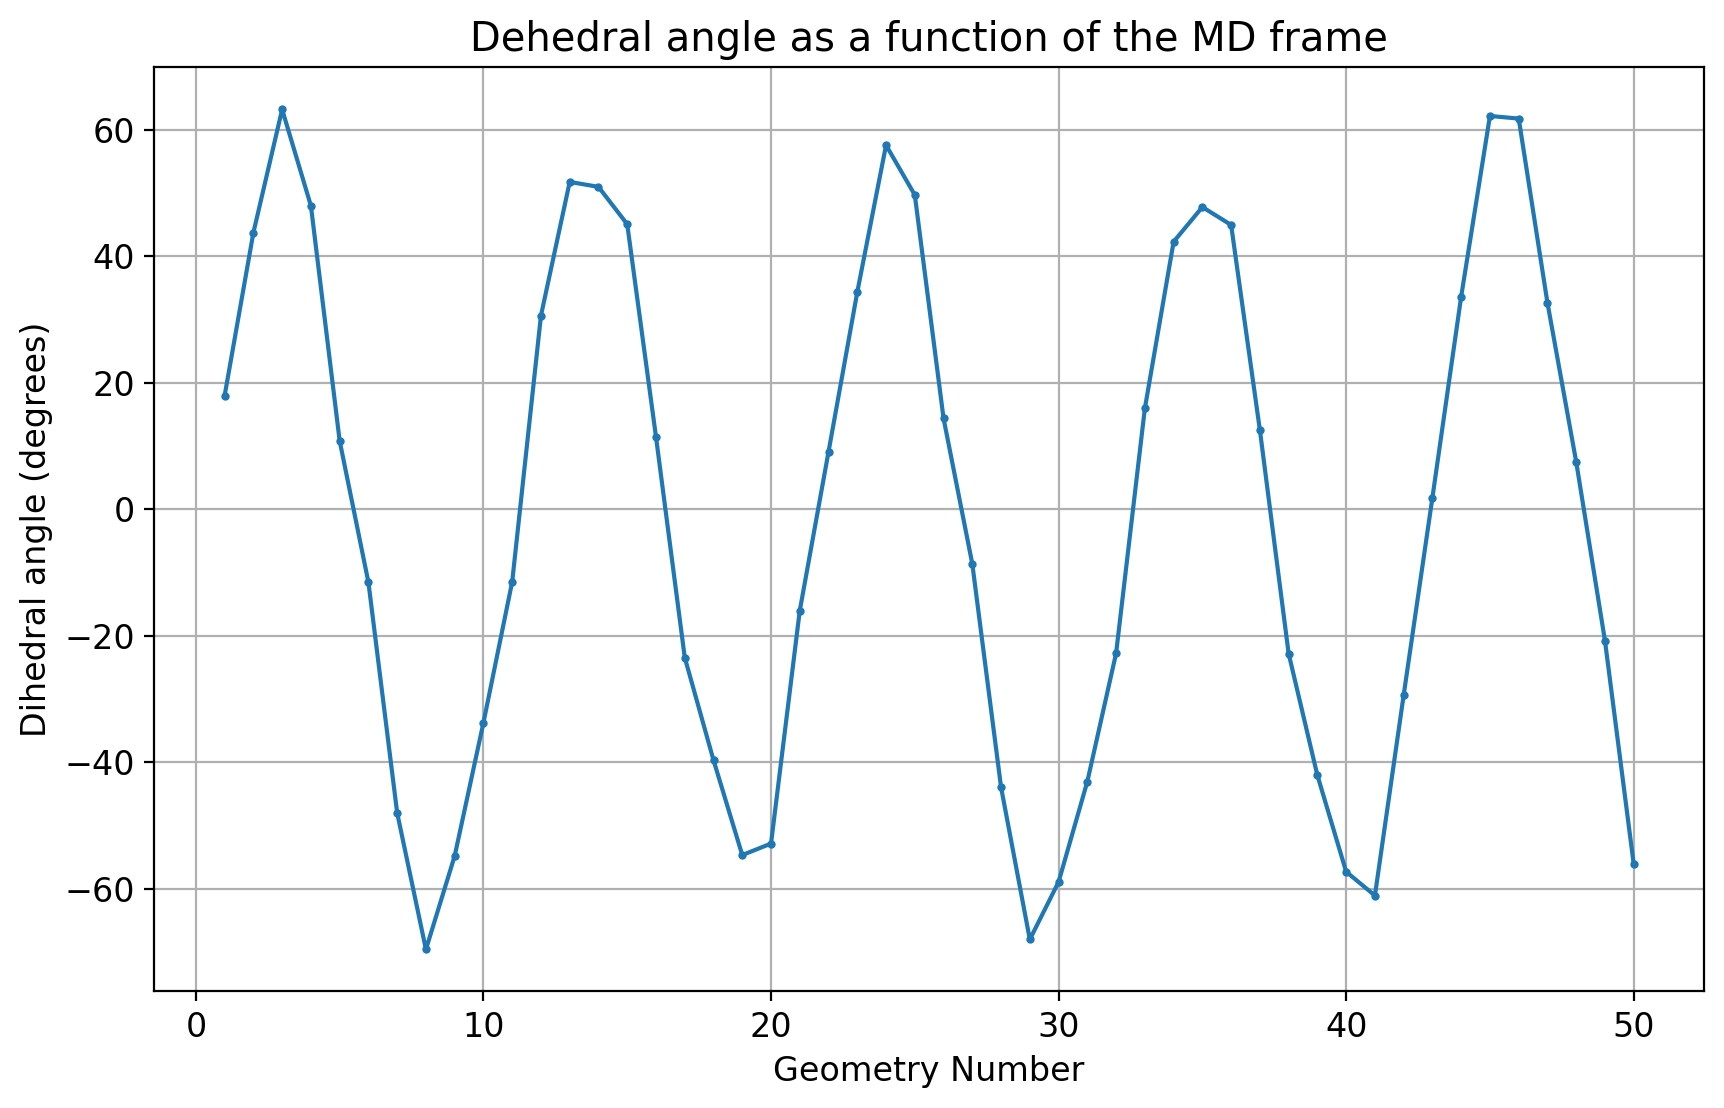

In [34]:
plot_data(t20_cis.data, 'dihedrals', 'Dihedral angle (degrees)', 'Dehedral angle as a function of the MD frame', save=f'dihedral_cis_{n}_0.png')

Next take the union of t20 and t20_cis, and train and compare to our reference with the added data points.

In [35]:
import pandas as pd
t20_50_50 = deepcopy(t20)
t20_50_50.data = pd.concat([t20_50_50.data, t20_cis.data], axis=0, ignore_index=True, sort=False)

Let us inspect the data to ensure we have correctly concatenated the two data sets.

In [36]:
t20_50_50.data[['coordinates','atoms','energy','gradient']]

,coordinates,atoms,energy,gradient
0,"[-1.758792198496, 0.488609923081, 0.0847808965...","[C, C, C, C, H, H, H, H, H, H]",-11.544214,"[-0.000982293806, -0.008253154471, -0.01117791..."
1,"[-1.649834761847, 0.524651371548, 0.1916536914...","[C, C, C, C, H, H, H, H, H, H]",-11.539112,"[0.02015416698, 0.012245020214, 0.008497904477..."
2,"[-1.812574088505, 0.423497025153, 0.0515438866...","[C, C, C, C, H, H, H, H, H, H]",-11.540379,"[-0.007183576556, 0.008608273681, 0.0048916808..."
3,"[-1.767780100749, 0.361255713891, 0.0399992375...","[C, C, C, C, H, H, H, H, H, H]",-11.548521,"[-0.001287849305, -0.009980958944, 0.000237307..."
4,"[-1.760985003349, 0.368729186591, 0.0591753011...","[C, C, C, C, H, H, H, H, H, H]",-11.548482,"[0.00044686763, -0.004644546387, 0.00423712348..."
...,...,...,...,...
95,"[-1.436833595829, 0.610256417747, 0.4254923233...","[C, C, C, C, H, H, H, H, H, H]",-11.539006,"[0.009097811086, 0.014929575748, -0.0228786042..."
96,"[-1.476090822861, 0.361181035799, 0.7380626409...","[C, C, C, C, H, H, H, H, H, H]",-11.541290,"[-0.003634124913, 0.004613398819, -0.001840707..."
97,"[-1.493690465243, 0.585623895164, 0.4979424920...","[C, C, C, C, H, H, H, H, H, H]",-11.538505,"[-0.007096895976, 0.012492069837, -0.019683693..."
98,"[-1.375077620089, 0.533753915934, 0.6164569200...","[C, C, C, C, H, H, H, H, H, H]",-11.542540,"[0.001510555776, 0.010825543854, -0.0053038399..."


If all is good, we are ready to train our combined model.

In [37]:
dp_data_50_50 = deepmd_engine.get_data(t20_50_50, data_dir=f'{deepmd_wrk}/wrk/t20_{n}_{n}')

model_50_50 = deepmd_engine.train(dp_data_50_50, run_opt={"sub_dir": "wrk/trained_models_{n}_{n}"})

And infer the model on our reference geometries.

In [38]:
predictions_50_50 = hsp.DataSet(deepmd_engine.infer(model_50_50["model"], reference))

For comparison, we also train solely on the *cis* generated geometries.

In [39]:
dp_data_0_50 = deepmd_engine.get_data(t20_cis, data_dir=f'{deepmd_wrk}/wrk/t20_0_{n}')

model_0_50 = deepmd_engine.train(dp_data_0_50, run_opt={"sub_dir": "wrk/trained_models_0_{n}"})

In [40]:
predictions_0_50 = hsp.DataSet(deepmd_engine.infer(model_0_50["model"], reference))

We are ready to plot and compare our three trained models.
> ($n$,$m$) means $n$ data points around the *trans* conformer and $m$ data points around the *cis* conformer

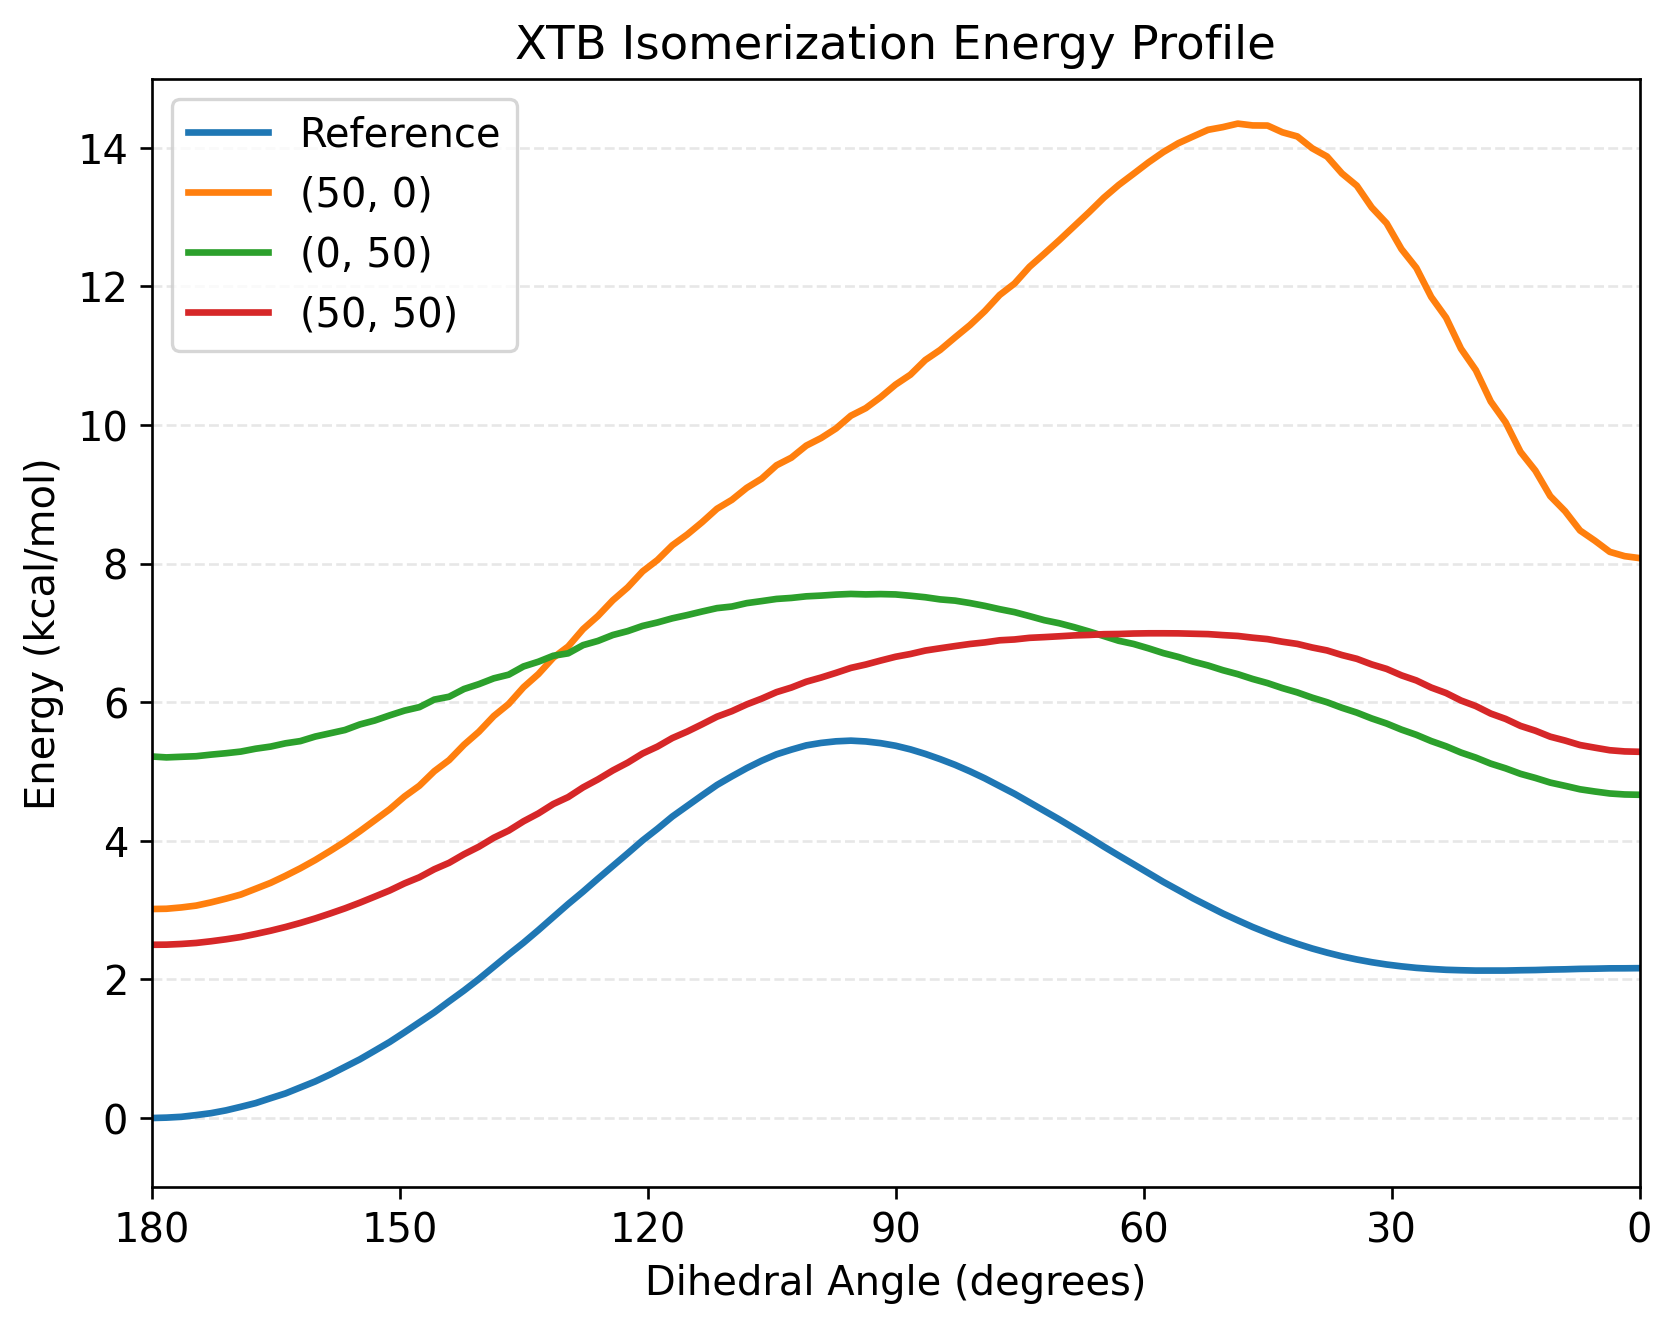

In [41]:
ref_M2 = min(predictions_50_50.data['energy'])
ylim=[-1,15]
plt = plot_energies(energies_hartree, reference_energy, label = 'Reference', ylim=ylim);
plt = plot_energies(predictions.data['energy'], reference_energy, add_to_plot=True, label = f'({n}, 0)', ylim=ylim);
plt = plot_energies(predictions_0_50.data['energy'], reference_energy, add_to_plot=True, label = f'(0, {n})', ylim=ylim);
fig = plot_energies(predictions_50_50.data['energy'], reference_energy, add_to_plot=True, label = f'({n}, {n})', ylim=ylim);

For a better comparison let us take the *trans*-conformer as the reference for each energy profile.

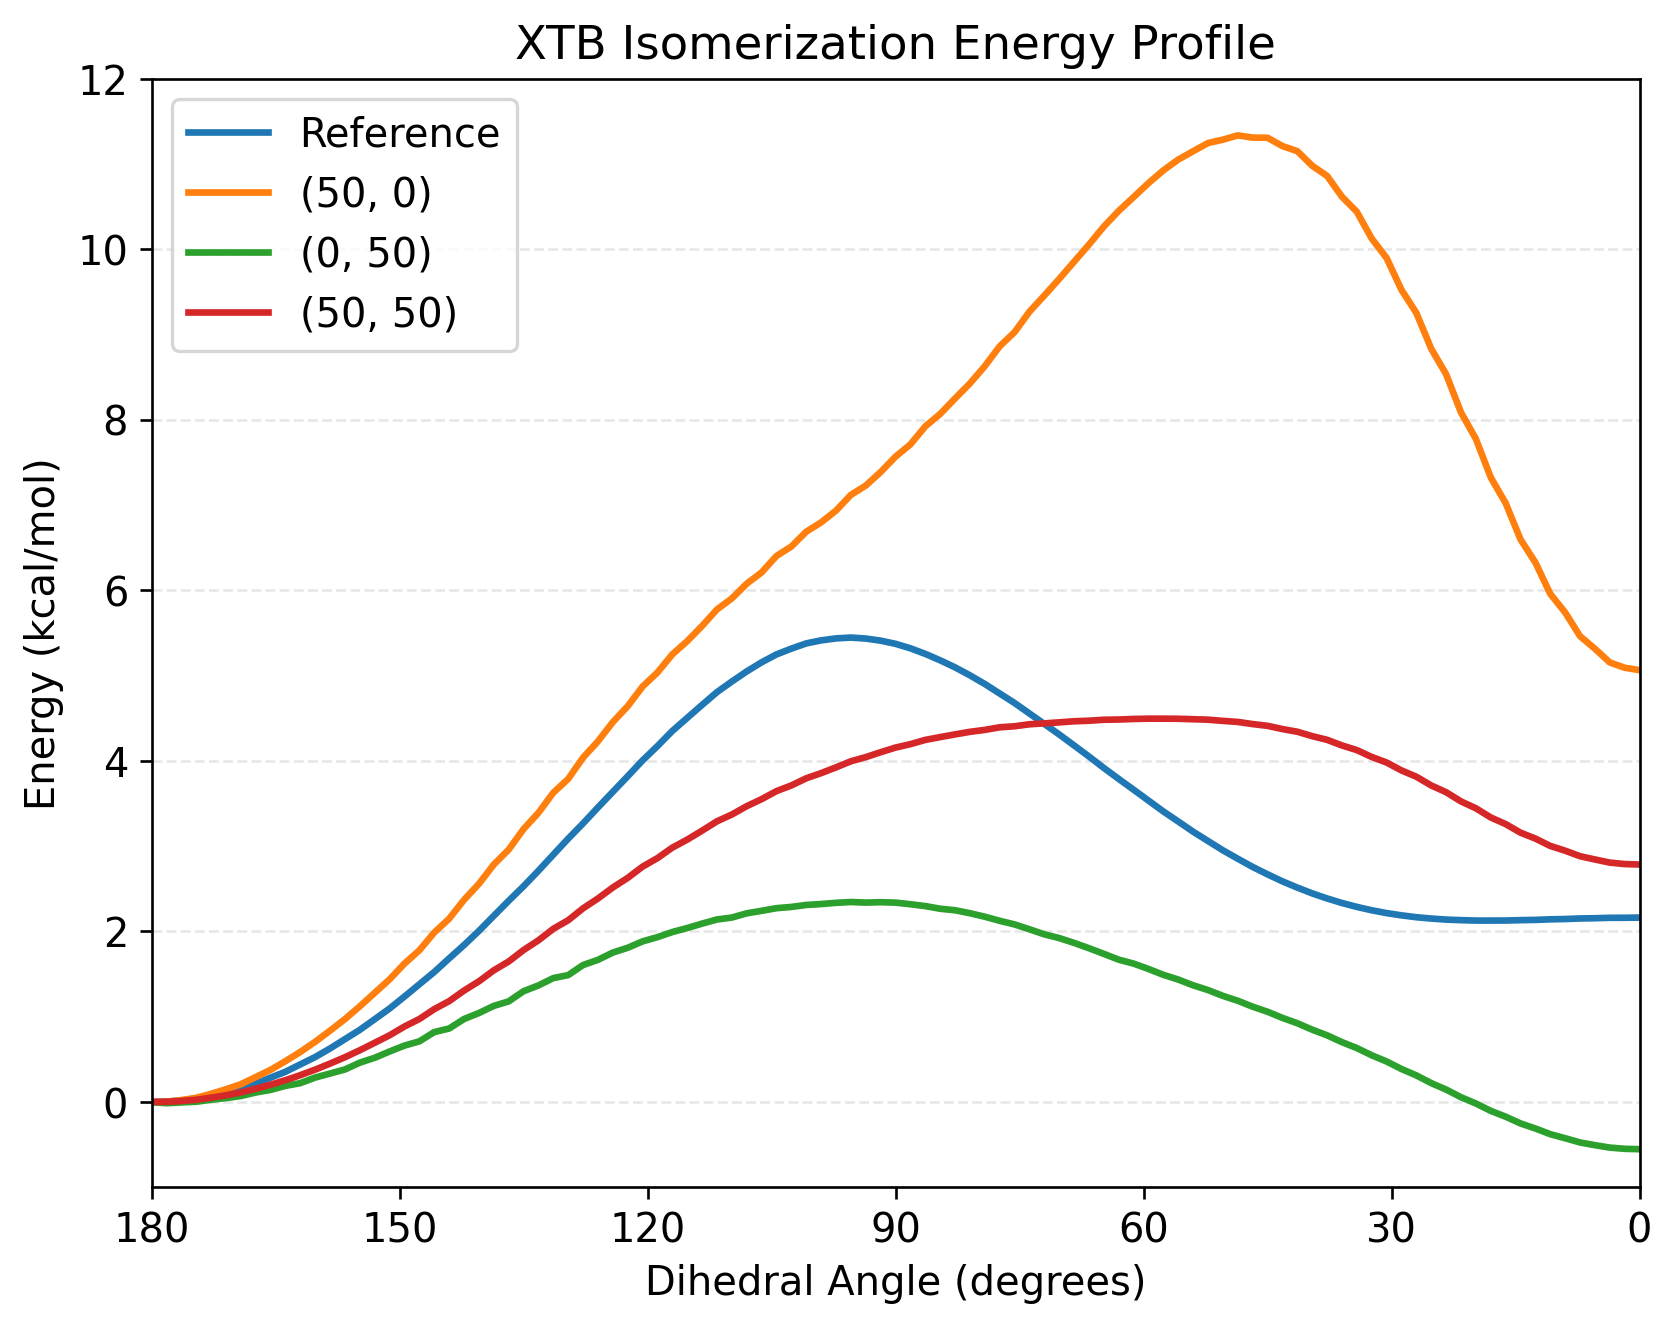

In [42]:
ref_M2 = min(predictions_50_50.data['energy'])
ref_M1 =predictions_0_50.data['energy'][0]
ylim=[-1,12]
plt = plot_energies(energies_hartree, reference_energy, label = 'Reference', ylim=ylim, save=f'model_{n}_0.png');
plt = plot_energies(predictions.data['energy'], ref_M, add_to_plot=True, label = f'({n}, 0)', ylim=ylim, save=f'model_{n}_1.png');
plt = plot_energies(predictions_0_50.data['energy'], ref_M1, add_to_plot=True, label = f'(0, {n})', ylim=ylim, save=f'model_{n}_2.png');
fig = plot_energies(predictions_50_50.data['energy'], ref_M2, add_to_plot=True, label = f'({n}, {n})', ylim=ylim, save=f'model_{n}_3.png');

Clearly, using data points around both the *cis* and *trans* conformer generates the overall best profile. However, our model is not able to infer any knowledge around the TS state, as we have no data points in this region.

Let us finally inspect the barrier hight of our combined model:

In [43]:
barrier = (max(predictions_50_50.data['energy'])-min(predictions_50_50.data['energy']))*hsp.Constants.conversion_factor("hartree", "kcal / mol")
print(f"Isomerization barrier for model ({n}, {n}) is {barrier:.2f} kcal/mol")

Isomerization barrier for model (50, 50) is 4.49 kcal/mol


> ToDO: 1) plot gradients, 2) train several models on the same data, and 3) train models with varying $n$

## Active Learning

We are now ready to explore the active-learning approach. For this we will use the hyal module, and in the same way as for the passive approach compare the MLPs with the reference data.

The HSP implementation of active learning start from an inital data set, and interatively combines the following main steps to train the MLPs:

- train the MLPs for a committee of models
- run a fast sampler to genereate candidates for new data points
- refine a selection of these candidates by minimizing an objective funtion (that includes the committee model devitations)
- generate new data points using a calculator

In the current example we will use: DeepMD for training, LAMMPS for sampling and XTB as calculator. The objective funtion to minimize in each AL iteration is:

$$equation$$

### Sampler

For the sampler we will use LAMMPS. We can steer the LAMMPS setting by modifying the LAMMPS input template: [lammps.inp](./templates/lammps.inp).


In [44]:
import hylleraas as hsp
from copy import deepcopy
import os
import numpy as np

debug = True
lammps_wrk=os.path.realpath('./')
lammps_conda = hsp.create_compute_settings('conda', 
                                           conda_env='hsp_active_learning', 
                                           work_dir=lammps_wrk, 
                                           force_recompute=True,
                                           debug=debug)

In [45]:
lammps_engine = hsp.Lammps(method={"units": "metal",
                                    "check_version": False}, 
                                    compute_settings = lammps_conda)

### ML model

For the ML model we will simply use the `deepmd_engine` we used for the passive learning.

In [46]:
import json

deepmd_wrk=os.path.realpath('./')+'/wrk_pbc/deepmd'
deepmd_conda = hsp.create_compute_settings('conda', 
                                            conda_env='hsp_al', 
                                            work_dir=deepmd_wrk, 
                                            force_recompute=True,
#                                            debug=debug)
                                            debug=True)

deepmd_input_dict = json.load(open('templates/deepmd_template.json', 'r'))
deepmd_engine = hsp.DeepMD(
    {
        'input': deepmd_input_dict,
        'debug': False,
        'check_version': False,
        'options': {},
    }, 
    compute_settings = deepmd_conda
)

### Calculator

For the calculator we will continue to use the `xtb_data_point`.

In [47]:
# This debug varaible is used throughout. For the final version simply turn off the debug 
# option, but it might come handy when setting up and testing the code -- to more easily 
# understand why the code fails in certain steps

debug = True

xtb_wrk=os.path.realpath('./')+'/wrk_pbc/xtb'
xtb_conda = hsp.create_compute_settings('conda', 
                                        conda_env='hsp_al', 
                                        work_dir=xtb_wrk, 
                                        debug=debug)

# XTB for geometry optimizations
xtb_geometry_optimization = hsp.Xtb({'properties': ['energy', 
                                                    'geometry_optimization',
                                                    'gradient']}, 
                                    compute_settings = xtb_conda)

# XTB for single point calaculations of the energy and gradient
xtb_data_point = hsp.Xtb({'properties': ['energy', 'gradient']}, 
                         compute_settings = xtb_conda)

DEBUG: (one of) output file(s) [PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out'), PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out')] exists
DEBUG: and will *not* be overwritten
DEBUG: QUICK RETURN: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out'), output_folder=None, stdout=None, stderr=None, returncode=None, error=None)
DEBUG: (one of) output file(s) [PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out'), PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out')] exists
DEBUG: and will *not* be overwritten
DEBUG: QUICK RETURN: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/xtb_version.out'), output_folder=None, stdout=None, stderr=None, retur

### AL model

For the active learning we will use hyal, which can be steered using a json template file: [hyal_settings.json](./templates/hyal_settings.json).

In [48]:
hyal_settings = json.load(open('templates/hyal_settings.json', 'r'))
# Setup sampling for lammps
hyal_settings['sampling_opts'] = {'butadiene': {'template': 'templates/lammps.inp'}}

In [49]:
import hyal
np.random.seed(0) # To avoid creating new geometries in make_initial_set! 

xyz='''10

C -1.740318000000 0.430948000000 0.064642000000
C -0.619681000000 -0.116079000000 0.467558000000
C 0.614285000000 0.118481000000 -0.245832000000
C 1.751101000000 -0.426794000000 0.149549000000
H -1.827155000000 1.074246000000 -0.797361000000
H -2.646902000000 0.238204000000 0.616993000000
H -0.608278000000 -0.746727000000 1.335847000000
H 0.597431000000 0.752131000000 -1.116548000000
H 1.799534000000 -1.067288000000 1.019770000000
H 2.679982000000 -0.257122000000 -0.377925000000'''
butadiene = hsp.Molecule(xyz, units = 'angstrom')
butadiene_pbc = hsp.PeriodicSystem(butadiene.translate([10.0,10.0,10.0]), pbc=np.eye(3)*50.0)

al = hyal.ActiveLearning(ml_engines=[deepmd_engine]*2,
                         calculator=xtb_data_point,
                         sampler=lammps_engine,
                         )

initial_set=al.make_initial_set({
        'butadiene_pbc': butadiene_pbc,
    }, 5, 0.1, sub_dir=xtb_wrk+'/al_results/')

initial_ds=al.generate_dataset(xtb_wrk+'/al_results/initial_set/butadiene_pbc') 

dpdata = deepmd_engine.get_data(initial_ds)
#dpdata.dump_data(data_dir='/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/deepmd/iter_0/mlp/dataset_DeepMD/butadiene_pbc')

# For this call to work, patch hyset/local/runner.py@265 by commenting it out. 
results = al.run(
    systems={
        'butadiene': butadiene,
    },
    options=[hyal_settings],
    initial_set=initial_set, 
    run_opt= {'sub_dir': xtb_wrk}
    )

DEBUG: (one of) output file(s) [PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b.out'), PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b.out'), PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b/678b0ee6d547106007ea0ae889549cb05c08b0e50a7c0c4a1020b6b0dd48149b.stderr')] exists
DEBUG: and will *not* be overwritten
DEBUG: QUICK RETURN: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/init

/Users/simenreine/miniconda3/envs/hsp_2024/lib/python3.10/site-packages/hyset/local/runner.py:299: UserWarning: normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  warnings.warn(result.stderr)


DEBUG: RESULTS: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/fcb37a880d122b90abef095701642e11694ccb11316c1e602c40b358cf583e15/fcb37a880d122b90abef095701642e11694ccb11316c1e602c40b358cf583e15.out'), output_folder=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/fcb37a880d122b90abef095701642e11694ccb11316c1e602c40b358cf583e15'), stdout=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/fcb37a880d122b90abef095701642e11694ccb11316c1e602c40b358cf583e15/fcb37a880d122b90abef095701642e11694ccb11316c1e602c40b358cf583e15.out'), stderr='normal termination of xtb\nNote: The following floating-point exceptions are signalling: IEEE_DENORMAL\n\n', returncode=0, error=None)
DEBUG: creating directory /Users/simenreine/HSP/hylleraas/docs/src/active_learning/w

/Users/simenreine/miniconda3/envs/hsp_2024/lib/python3.10/site-packages/hyset/local/runner.py:299: UserWarning: normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  warnings.warn(result.stderr)


DEBUG: RESULTS: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/6bf68d10155325b9280725f94d749fc801cdf4da4b68cb65038c623143e6326b/6bf68d10155325b9280725f94d749fc801cdf4da4b68cb65038c623143e6326b.out'), output_folder=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/6bf68d10155325b9280725f94d749fc801cdf4da4b68cb65038c623143e6326b'), stdout=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/6bf68d10155325b9280725f94d749fc801cdf4da4b68cb65038c623143e6326b/6bf68d10155325b9280725f94d749fc801cdf4da4b68cb65038c623143e6326b.out'), stderr='normal termination of xtb\nNote: The following floating-point exceptions are signalling: IEEE_DENORMAL\n\n', returncode=0, error=None)
DEBUG: creating directory /Users/simenreine/HSP/hylleraas/docs/src/active_learning/w

/Users/simenreine/miniconda3/envs/hsp_2024/lib/python3.10/site-packages/hyset/local/runner.py:299: UserWarning: normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  warnings.warn(result.stderr)


DEBUG: RESULTS: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/de0a871bcbd861869354f99bb03b72b0f35ec66f0601d853c951d7cc4b4ecae9/de0a871bcbd861869354f99bb03b72b0f35ec66f0601d853c951d7cc4b4ecae9.out'), output_folder=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/de0a871bcbd861869354f99bb03b72b0f35ec66f0601d853c951d7cc4b4ecae9'), stdout=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/de0a871bcbd861869354f99bb03b72b0f35ec66f0601d853c951d7cc4b4ecae9/de0a871bcbd861869354f99bb03b72b0f35ec66f0601d853c951d7cc4b4ecae9.out'), stderr='normal termination of xtb\nNote: The following floating-point exceptions are signalling: IEEE_DENORMAL\n\n', returncode=0, error=None)
DEBUG: creating directory /Users/simenreine/HSP/hylleraas/docs/src/active_learning/w

/Users/simenreine/miniconda3/envs/hsp_2024/lib/python3.10/site-packages/hyset/local/runner.py:299: UserWarning: normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  warnings.warn(result.stderr)


DEBUG: RESULTS: LocalResult(files_to_parse=[], output_file=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/7a152600d17c66caede2be41f52631b6b6f5e33e53f1d9573baf4e50e3dad872/7a152600d17c66caede2be41f52631b6b6f5e33e53f1d9573baf4e50e3dad872.out'), output_folder=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/7a152600d17c66caede2be41f52631b6b6f5e33e53f1d9573baf4e50e3dad872'), stdout=PosixPath('/Users/simenreine/HSP/hylleraas/docs/src/active_learning/wrk_pbc/xtb/al_results/initial_set/butadiene_pbc/7a152600d17c66caede2be41f52631b6b6f5e33e53f1d9573baf4e50e3dad872/7a152600d17c66caede2be41f52631b6b6f5e33e53f1d9573baf4e50e3dad872.out'), stderr='normal termination of xtb\nNote: The following floating-point exceptions are signalling: IEEE_DENORMAL\n\n', returncode=0, error=None)
could not find either input or output files
could not find either input or output fi

TypeError: data must be a DeepMDData, a DataSet, dict or a path

In [ ]:
initial_ds = al.generate_dataset(xtb_wrk+'/al_results/initial_set/butadiene_pbc') 
deepmd_engine.get_data(initial_ds)

In [ ]:
import hylleraas as hsp
from pathlib import Path

settings = hsp.create_compute_settings(
    "conda",
    conda_env="conda_xtb",
    debug=True,
    work_dir=Path(Path.cwd()).resolve() / "xtb",
)

xtb = hsp.Xtb(
    {
        "properties": [
            "energy", "gradient"
        ],
    },
    compute_settings=settings,
)

water = hsp.Molecule("O")

xtb.run(water, run_opt={'sub_dir':'sub'})
print(Path(Path.cwd()).resolve() / "xtb")

data_dir = Path(Path.cwd()).resolve() / "xtb" / "sub"
#data_dir = xtb_wrk + '/reference'
ds = hsp.DataSet(
    data_dir,
    parser=xtb.OutputParser,
    parse=True,
    match=["*.out"],
    keys=["energy", "gradient"],
)

ds.data

In [ ]:
reference_path=xtb_wrk + '/reference'
print(reference_path)
reference = hsp.DataSet(reference_path,
                        parser=xtb_data_point.OutputParser,
                        parse=True,
                        match=['*.out'],
                        keys=['energy', 'gradient'],
                        units=xtb_data_point.units)

reference.data

In [ ]:
import hylleraas as hsp
from pathlib import Path

settings = hsp.create_compute_settings(
    "conda",
    conda_env="conda_xtb",
    debug=True,
    work_dir=Path(Path.cwd()).resolve() / "xtb",
)

xtb = hsp.Xtb(
    {
        "properties": [
            "energy", "gradient"
        ],
    },
    compute_settings=settings,
)

water = hsp.Molecule("O")

xtb.run(water)
print(Path(Path.cwd()).resolve() / "xtb")

data_dir = Path(Path.cwd()).resolve() / "xtb"
#data_dir = xtb_wrk + '/reference'
ds = hsp.DataSet(
    data_dir,
    parser=xtb.OutputParser,
    parse=True,
    match=["*.out"],
    keys=["energy", "gradient"],
)

ds.data

In [ ]:
import hylleraas as hsp
from copy import deepcopy
import os

# This debug varaible is used throughout. For the final version simply turn off the debug 
# option, but it might come handy when setting up and testing the code -- to more easily 
# understand why the code fails in certain steps

debug = True

xtb_wrk=os.path.realpath('./')+'/new_wrk'
settings = hsp.create_compute_settings(
    "conda",
    conda_env="conda_xtb",
    debug=True,
    work_dir=xtb_wrk,
)

# XTB for geometry optimizations
xtb_geo = hsp.Xtb({'properties': ['energy', 'geometry_optimization', 'gradient']}, compute_settings = settings)

# XTB for single point calaculations of the energy and gradient
xtb_data = hsp.Xtb({'properties': ['energy', 'gradient']}, compute_settings = settings)

butadiene = hsp.Molecule('C=C-C=C')

result1 = xtb_geo.run(butadiene, run_opt= {'sub_dir': 'xtb'})
butadiene.coordinates = result1['final_geometry']

cis_butadiene = hsp.Molecule('''10

C -1.400150994841 0.478261820795 0.653083308889
C -0.812338402479 -0.485323350903 -0.046430688156
C 0.584996434273 -0.511370269276 -0.451098308709
C 1.559580367935 0.220696578716 0.075783220254
H -0.867416026674 1.355029383734 0.979605859109
H -2.442852127711 0.429878660025 0.916297784711
H -1.400778838995 -1.332818613746 -0.376026609302
H 0.820069874536 -1.213078365816 -1.241977606761
H 1.384366514399 0.911344527785 0.882907991820
H 2.574522199558 0.147379628686 -0.275451951853''')


result2 = xtb_geo.run(cis_butadiene, run_opt= {'sub_dir': 'xtb'})

cis_butadiene.coordinates = result2['final_geometry']
hsp.view_molecule(butadiene);
hsp.view_molecule(cis_butadiene);

print(butadiene.coordinates-cis_butadiene.coordinates)